# USE ME FOR PROJECT DOCUMENTATIONS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Lambda, Input, Dense, Embedding, multiply, Flatten, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# STEP 2: DATA EXPLORATORY

# Preamble

Prior to synthetic data generation, data preprocessing steps were meticulously applied to each dataset, ensuring data cleanliness, normalization, and partitioning into the said two main component data. The original dataset, comprising 80% of the total data, served as the foundation for generating synthetic data. In contrast, the remaining 20%, referred to as control data, was reserved for evaluating both the privacy risks associated with the synthetic dataset and the utility as well.

# Ensuring Privacy Preservation and Data Utility
1. Privacy Preservation: By using an autoencoder to generate synthetic data, we minimize the risk of exposing original data entries. The classifier's role is solely to provide labels for synthetic instances, further abstracting the process from direct data duplication.

2. Data Utility: The utility of the synthetic data is maintained through the autoencoder's ability to capture and replicate the complex relationships in the original data. The trained classifier ensures that synthetic data receives labels that are consistent with the learned patterns, making the synthetic dataset useful for downstream tasks.


# Purpose of the Control Dataset
1. Benchmarking Privacy Leakage: The control dataset (control_data_df) is used to differentiate what an attacker learns purely from the synthetic dataset's utility versus what constitutes an actual privacy leak. By comparing the success of attacks on the control dataset against those on the original dataset, one can more accurately assess the extent of privacy risk.

2. Ensuring Fair Evaluation: It ensures that the assessment accounts for the possibility that the synthetic dataset might inadvertently reveal specific patterns or information that could lead to re-identification or information inference not due to the inherent utility of the synthetic data but due to direct data leakage.

# Creating a Control Dataset
The control dataset should consist of records that are not included in the synthetic dataset's generation process. Here's how to create or obtain a control dataset:

1. Splitting Original Data: Before generating your synthetic dataset, split your original dataset into two parts. One part is used to generate the synthetic dataset (original_data_df), and the other part serves as the control dataset (control_data_df). This way, the control dataset contains real data points that were not used to train the model creating the synthetic data, ensuring they share similar distributions without direct overlaps.



# Anonymeter Tool
Anonymeter’s development as an open-source tool underlines Anonos’s commitment to enhancing privacy technologies’ accessibility. It is crafted to be adaptable, ensuring it remains relevant amid evolving privacy regulations and research advancements. The Anonymeter framework plays a pivotal role in the field of synthetic data by providing a structured approach to evaluate and mitigate privacy risks. By assessing singling-out, linkability, and inference risks, Anonymeter helps researchers and practitioners balance the trade-offs between maintaining data utility and ensuring privacy. This is particularly relevant in the era of big data and machine learning, where the use of synthetic data is becoming increasingly prevalent. For more information on this tool, including its installation and configurations, do visit their website and github via the links below.

https://www.anonos.com/blog/presenting-anonymeter-the-tool-for-assessing-privacy-risks-in-synthetic-datasets

https://github.com/statice/anonymeter

In [2]:
# Load the dataset
lowerBackPain_df = pd.read_csv('C:\\Users\\Ede\\Desktop\\Synthetic_Real_Data_Using_AE_VAE_Techniques\\master_thesis2024\\lower-Back-Pains.csv')

# Display the first few rows of the dataframe
lowerBackPain_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


In [3]:
# Display the first few rows of the dataframe
lowerBackPain_df.tail()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0.129744,7.8433,14.7484,8.51707,-15.728927,11.5472,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0.047913,19.1986,18.1972,7.08745,6.013843,43.8693,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0.081070,16.2059,13.5565,8.89572,3.564463,18.4151,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0.159251,14.7334,16.0928,9.75922,5.767308,33.7192,Normal
309,33.841641,5.073991,36.641233,28.767649,123.945244,-0.199249,0.674504,19.3825,17.6963,13.72929,1.783007,40.6049,Normal


In [4]:
# Basic information about the dataset
lowerBackPain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   pelvic_slope              310 non-null    float64
 7   direct_tilt               310 non-null    float64
 8   thoracic_slope            310 non-null    float64
 9   cervical_tilt             310 non-null    float64
 10  sacrum_angle              310 non-null    float64
 11  scoliosis_slope           310 non-null    float64
 12  Class_att                 310 non-null    object 
dtypes: float64(12), object(1)
memory usage: 31.6+ KB


In [5]:
# Descriptive statistics
lowerBackPain_df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200


In [6]:
# Check for missing values
lowerBackPain_df.isnull().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64

In [7]:
# Assuming 'Class_att' is your target column with binary classes 0 and 1
class_counts = lowerBackPain_df['Class_att'].value_counts()
total_counts = len(lowerBackPain_df)

# Calculate class percentages
class_percentages = (class_counts / total_counts) * 100

# Print class percentages
print("Class Percentages:")
print(class_percentages)

# Check if the data is imbalanced
if abs(class_percentages[0] - class_percentages[1]) > 20:  # You can adjust this threshold
    print("\nThe dataset is imbalanced.")
else:
    print("\nThe dataset is balanced.")

Class Percentages:
Abnormal    67.741935
Normal      32.258065
Name: Class_att, dtype: float64

The dataset is imbalanced.


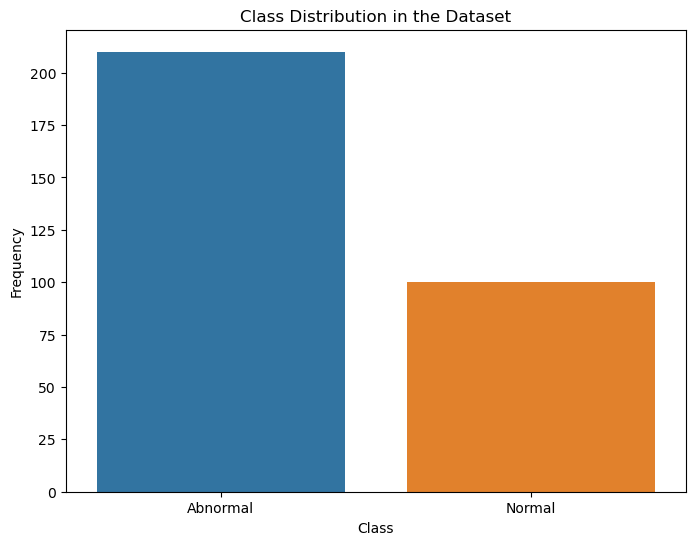

In [8]:
# Assuming 'Class_att' is your target column
class_counts = lowerBackPain_df['Class_att'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')
plt.show()

In [8]:
# Handling Categorical Data
# Since your dataset contains a categorical column (Class_att), you'll need to encode it if you plan to use it in machine learning models.
from sklearn.preprocessing import LabelEncoder

# Encode the 'Class_att' column
label_encoder = LabelEncoder()
lowerBackPain_df['Class_att'] = label_encoder.fit_transform(lowerBackPain_df['Class_att'])

# Verify encoding
lowerBackPain_df['Class_att'].head()

0    0
1    0
2    0
3    0
4    0
Name: Class_att, dtype: int32

# Partioning the Original Data into 80% and 20% respectiively as shown below

In [9]:
lowerBackPain_train_dataframe, control_lbp_dataframe = train_test_split(lowerBackPain_df, test_size=0.2, random_state=42)

In [10]:
lowerBackPain_train_dataframe.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
126,70.676898,21.704402,59.181161,48.972496,103.008354,27.810148,0.039655,15.7748,14.8568,11.45991,-18.475476,19.8407,0
109,68.613001,15.082235,63.014696,53.530766,123.431174,39.497987,0.249351,27.0646,17.7171,7.18220,-20.883262,17.1130,0
247,49.828135,16.736435,28.000000,33.091700,121.435558,1.913307,0.487834,30.4187,15.5507,15.89565,-28.277945,22.0420,1
234,37.731992,9.386298,42.000000,28.345694,135.740926,13.683047,0.465170,28.9703,10.2016,11.24951,-19.160909,34.0011,1
202,76.314028,41.933683,93.284863,34.380345,132.267286,101.218783,0.218939,31.5204,13.6555,12.22936,4.894807,16.5217,0


In [11]:
lowerBackPain_train_dataframe.tail()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
188,85.680950,38.650035,82.680977,47.030914,120.840707,61.959034,0.807919,24.8883,13.2380,10.73285,0.627326,11.2469,0
71,86.900794,32.928168,47.794347,53.972627,135.075364,101.719092,0.459674,25.0986,8.7655,8.93510,-21.318960,12.8518,0
106,65.013773,9.838262,57.735837,55.175511,94.738525,49.696955,0.151994,14.3986,8.9024,10.84295,6.573829,35.1025,0
270,51.311771,8.875541,57.000000,42.436230,126.472258,-2.144044,0.467413,22.7101,10.5134,10.13608,5.738583,36.7874,1
102,70.399308,13.469986,61.200000,56.929322,102.337524,25.538429,0.974401,30.9297,9.5431,12.34978,6.089565,34.9908,0


In [12]:
control_lbp_dataframe.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
289,44.430701,14.174264,32.243495,30.256437,131.717613,-3.604255,0.126792,15.1269,7.9912,12.23055,-26.340144,32.3929,1
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,0.367700,26.2011,8.7380,14.91416,-1.702097,21.4320,0
57,46.855781,15.351514,38.000000,31.504267,116.250917,1.662706,0.121465,30.2830,14.6233,8.75046,4.334375,16.8302,0
60,74.377678,32.053104,78.772013,42.324573,143.560690,56.125906,0.159378,35.9529,15.3975,11.71169,-18.628293,22.5623,0
25,54.124920,26.650489,35.329747,27.474432,121.447011,1.571205,0.928688,14.6686,13.5700,16.12951,-17.630363,28.1902,0


In [35]:
control_lbp_dataframe.tail() 

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
198,74.854480,13.909084,62.693259,60.945396,115.208701,33.172255,0.821915,20.4667,9.3510,14.37763,4.230442,39.2266,0
195,71.241764,5.268270,85.999584,65.973493,110.703107,38.259864,0.506379,23.0527,15.2430,14.14875,-19.895641,8.6239,0
210,38.505273,16.964297,35.112814,21.540976,127.632875,7.986683,0.396364,34.8106,12.7802,15.24996,-28.833891,18.0442,1
224,89.834676,22.639217,90.563461,67.195460,100.501192,3.040973,0.379933,9.4868,17.7556,10.98189,-16.891891,28.0900,1
158,57.035097,0.345728,49.198003,56.689369,103.048698,52.165145,0.561323,35.4921,14.1033,7.99506,-26.223143,40.1564,0


In [14]:
# Assuming 'Class_att' is your target column with binary classes 0 and 1
class_counts = lowerBackPain_train_dataframe['Class_att'].value_counts()
total_counts = len(lowerBackPain_train_dataframe)
print(total_counts) 

248


In [15]:
# Verify encoding
lowerBackPain_df['Class_att'].head()

0    0
1    0
2    0
3    0
4    0
Name: Class_att, dtype: int32

In [16]:
# Verify encoding
lowerBackPain_train_dataframe['Class_att'].head()

126    0
109    0
247    1
234    1
202    0
Name: Class_att, dtype: int32

In [17]:
lowerBackPain_train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 126 to 102
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          248 non-null    float64
 1   pelvic_tilt               248 non-null    float64
 2   lumbar_lordosis_angle     248 non-null    float64
 3   sacral_slope              248 non-null    float64
 4   pelvic_radius             248 non-null    float64
 5   degree_spondylolisthesis  248 non-null    float64
 6   pelvic_slope              248 non-null    float64
 7   direct_tilt               248 non-null    float64
 8   thoracic_slope            248 non-null    float64
 9   cervical_tilt             248 non-null    float64
 10  sacrum_angle              248 non-null    float64
 11  scoliosis_slope           248 non-null    float64
 12  Class_att                 248 non-null    int32  
dtypes: float64(12), int32(1)
memory usage: 26.2 KB


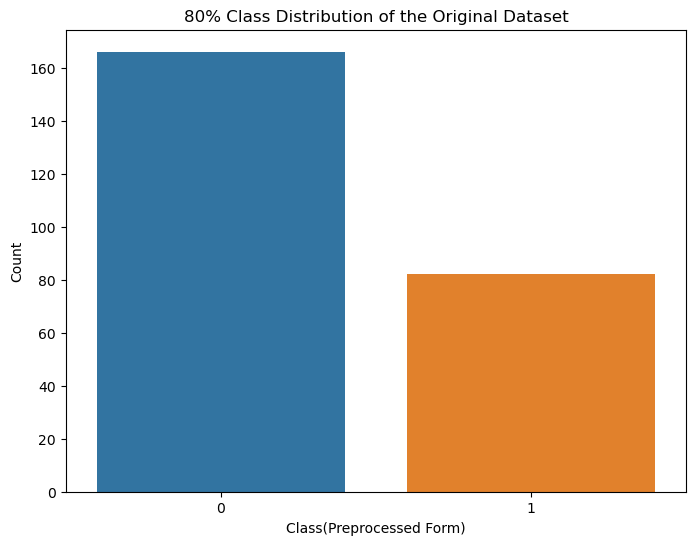

In [19]:
import matplotlib.pyplot as plt
# Assuming 'Class_att' is your target column
class_counts = lowerBackPain_train_dataframe['Class_att'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class(Preprocessed Form)')
plt.ylabel('Count')
plt.title('80% Class Distribution of the Original Dataset')
plt.show()

In [ ]:
# Load the Obesity dataset
# obesity_df = pd.read_csv('C:\\Users\\Ede\\Desktop\\Synthetic_Data_Using_AE_VAE_Techniques\\obesity.csv')

# Separate features and target
# features2 = lowerBackPain_train_dataframe.drop('Class_att', axis=1)
# labels2 = lowerBackPain_train_dataframe['Class_att']

# Normalize the features using MinMaxScaler for 0 to 1 range
# scaler = MinMaxScaler()
# features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
# X_train_real_new, X_test_real_new, y_train_real_new, y_test_real_new = train_test_split(features2, labels2, test_size=0.2, random_state=42)

# Convert to DataFrame and Series for compatibility
# X_train_real = pd.DataFrame(X_train_real, columns=features.columns)
# X_test_real = pd.DataFrame(X_test_real, columns=features.columns)
# y_train_real = pd.Series(y_train_real).reset_index(drop=True)
# y_test_real = pd.Series(y_test_real).reset_index(drop=True)

# Confirm the shapes
print("X_train_real_new shape:", X_train_real_new.shape)
print("X_test_real_new shape:", X_test_real_new.shape)
print("y_train_real_new shape:", y_train_real_new.shape)
print("y_test_real_new shape:", y_test_real_new.shape)

# STEP 3: DEFINING AND TRAINING VARIATIONAL AUTOENCODER MODEL, AND GENERATE THE RELEVANT SYNTHETIC DATASET THAT MIMICS ORIGINAL DATA

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier

# Separate features and labels from the lower back pain dataset
features2 = lowerBackPain_train_dataframe.drop('Class_att', axis=1)
labels2 = lowerBackPain_train_dataframe['Class_att']

# Split the dataset into training (80%) and testing (20%) subsets with a random state for reproducibility
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(features2, labels2, test_size=0.2, random_state=42)

# Normalize features to be between 0 and 1 to improve model training efficiency and performance
scaler = MinMaxScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real)
X_test_real_scaled = scaler.transform(X_test_real)

# Define input dimensions and number of unique classes for the model based on the dataset
input_dim = X_train_real_scaled.shape[1]
num_classes = len(np.unique(y_train_real))

# Set the dimensionality of the latent space (hidden representation space)
latent_dim = 12  

# Define a function to sample from the latent space, using a reparameterization trick for training stability
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder model: maps inputs and labels to a latent distribution parameters
inputs = Input(shape=(input_dim, ))
labels_input = Input(shape=(1,), dtype='int32')
labels_embedding = Flatten()(Embedding(num_classes, input_dim)(labels_input))
inputs_cond = Concatenate(axis=-1)([inputs, labels_embedding])
x = Dense(64, activation='relu')(inputs_cond)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder model: reconstructs inputs from latent space and labels
latent_inputs = Input(shape=(latent_dim,))
labels_embedding_dec = Flatten()(Embedding(num_classes, latent_dim)(labels_input))
latent_cond = Concatenate(axis=-1)([latent_inputs, labels_embedding_dec])
x_decoded = Dense(64, activation='relu')(latent_cond)
outputs = Dense(input_dim, activation='sigmoid')(x_decoded)

# Instantiate the encoder and decoder models
vae_encoder = Model([inputs, labels_input], [z_mean, z_log_var, z], name='vae_encoder')
vae_decoder = Model([latent_inputs, labels_input], outputs, name='vae_decoder')

# Complete VAE model
outputs_vae = vae_decoder([vae_encoder([inputs, labels_input])[2], labels_input])
vae_backpain = Model([inputs, labels_input], outputs_vae, name='vae_backpain')

# Define the VAE loss function combining reconstruction and KL divergence loss
reconstruction_loss = K.sum(K.binary_crossentropy(inputs, outputs_vae), axis=-1)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_backpain.add_loss(vae_loss)
vae_backpain.compile(optimizer='adam')

# Train the VAE model with scaled features and labels
vae_backpain.fit([X_train_real_scaled, y_train_real], features2, epochs=2500, batch_size=32, validation_split=0.2)

# Function to generate synthetic data using the trained VAE model
def generate_synthetic_data(num_samples, num_classes):
    # Generate random samples from a standard normal distribution to simulate the latent space input.
    # `num_samples` defines how many synthetic samples to generate.
    # `latent_dim` is the dimensionality of the latent space defined in the VAE model.
    latent_samples = np.random.normal(size=(num_samples, latent_dim))
    
    # Randomly generate integer labels corresponding to the classes of the dataset. This simulates categorical labels.
    # `num_classes` is the total number of unique classes in the dataset.
    sampled_labels = np.random.randint(0, num_classes, num_samples)
    
    # Use the trained VAE decoder model to predict the output from the latent space.
    # The decoder takes as input the latent samples and the corresponding labels, both of which are necessary
    # because the VAE model was trained to take inputs conditioned on labels (this is seen in the merging of inputs and labels in the encoder part).
    synthetic_data = vae_decoder.predict([latent_samples, sampled_labels])
    
    # The function returns the synthetic data matrix along with their corresponding generated labels.
    # These outputs can be used for further analysis, testing, or as augmented data for training other models.
    return synthetic_data, sampled_labels

# Generate synthetic data
synthetic_data, synthetic_labels = generate_synthetic_data(248, num_classes)

# Scale synthetic data back to original feature space
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)

# Convert synthetic data to DataFrame and Series for easier handling
vae_synthetic_data_df = pd.DataFrame(synthetic_data_rescaled, columns=features2.columns)
vae_synthetic_labels_series = pd.Series(synthetic_labels, name='Class_att')

# Display a sample of the generated synthetic data and labels
print(vae_synthetic_data_df.head())
print(vae_synthetic_labels_series.head())




Epoch 1/2500
5/5 [==============================] - 2s 78ms/step - loss: 9.1027 - val_loss: 8.7654
Epoch 2/2500
5/5 [==============================] - 0s 11ms/step - loss: 8.8168 - val_loss: 8.5537
Epoch 3/2500
5/5 [==============================] - 0s 11ms/step - loss: 8.6109 - val_loss: 8.4931
Epoch 4/2500
5/5 [==============================] - 0s 14ms/step - loss: 8.4776 - val_loss: 8.4993
Epoch 5/2500
5/5 [==============================] - 0s 12ms/step - loss: 8.3782 - val_loss: 8.3522
Epoch 6/2500
5/5 [==============================] - 0s 12ms/step - loss: 8.3144 - val_loss: 8.3172
Epoch 7/2500
5/5 [==============================] - 0s 10ms/step - loss: 8.1940 - val_loss: 8.1384
Epoch 8/2500
5/5 [==============================] - 0s 12ms/step - loss: 8.1401 - val_loss: 8.3047
Epoch 9/2500
5/5 [==============================] - 0s 13ms/step - loss: 8.0874 - val_loss: 8.1639
Epoch 10/2500
5/5 [==============================] - 0s 19ms/step - loss: 8.0042 - val_loss: 8.0650
Epoch 1

5/5 [==============================] - 0s 14ms/step - loss: 7.6685 - val_loss: 7.9123
Epoch 160/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6683 - val_loss: 7.8997
Epoch 161/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6676 - val_loss: 7.9282
Epoch 162/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6569 - val_loss: 7.9007
Epoch 163/2500
5/5 [==============================] - 0s 15ms/step - loss: 7.6601 - val_loss: 7.9175
Epoch 164/2500
5/5 [==============================] - 0s 15ms/step - loss: 7.6681 - val_loss: 7.9032
Epoch 165/2500
5/5 [==============================] - 0s 15ms/step - loss: 7.6480 - val_loss: 7.9162
Epoch 166/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6584 - val_loss: 7.9068
Epoch 167/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6700 - val_loss: 7.9272
Epoch 168/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6634 - val_loss: 7.9391
Epoch

5/5 [==============================] - 0s 12ms/step - loss: 7.6446 - val_loss: 7.9160
Epoch 322/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6579 - val_loss: 7.9008
Epoch 323/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6458 - val_loss: 7.8983
Epoch 324/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6516 - val_loss: 7.9129
Epoch 325/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6442 - val_loss: 7.9076
Epoch 326/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6412 - val_loss: 7.8900
Epoch 327/2500
5/5 [==============================] - 0s 14ms/step - loss: 7.6497 - val_loss: 7.9383
Epoch 328/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6549 - val_loss: 7.9056
Epoch 329/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6456 - val_loss: 7.8915
Epoch 330/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6529 - val_loss: 7.9113
Epoch

5/5 [==============================] - 0s 12ms/step - loss: 7.6551 - val_loss: 7.9093
Epoch 484/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6429 - val_loss: 7.8950
Epoch 485/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6461 - val_loss: 7.9015
Epoch 486/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6396 - val_loss: 7.9134
Epoch 487/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6433 - val_loss: 7.8980
Epoch 488/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6447 - val_loss: 7.9186
Epoch 489/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6475 - val_loss: 7.8891
Epoch 490/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6443 - val_loss: 7.8857
Epoch 491/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6465 - val_loss: 7.9126
Epoch 492/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6523 - val_loss: 7.8742
Epoch 

5/5 [==============================] - 0s 9ms/step - loss: 7.6521 - val_loss: 7.9016
Epoch 646/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6477 - val_loss: 7.9012
Epoch 647/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6413 - val_loss: 7.9030
Epoch 648/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6459 - val_loss: 7.9037
Epoch 649/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6378 - val_loss: 7.8998
Epoch 650/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6524 - val_loss: 7.9087
Epoch 651/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6441 - val_loss: 7.9135
Epoch 652/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6469 - val_loss: 7.9113
Epoch 653/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6464 - val_loss: 7.9172
Epoch 654/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6491 - val_loss: 7.9049
Epoch 65

5/5 [==============================] - 0s 10ms/step - loss: 7.6580 - val_loss: 7.8923
Epoch 808/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6475 - val_loss: 7.9013
Epoch 809/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6453 - val_loss: 7.8986
Epoch 810/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6441 - val_loss: 7.8996
Epoch 811/2500
5/5 [==============================] - 0s 18ms/step - loss: 7.6455 - val_loss: 7.8973
Epoch 812/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6467 - val_loss: 7.9064
Epoch 813/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6480 - val_loss: 7.9005
Epoch 814/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6481 - val_loss: 7.8771
Epoch 815/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6473 - val_loss: 7.9111
Epoch 816/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6401 - val_loss: 7.8808
Epoch 8

5/5 [==============================] - 0s 11ms/step - loss: 7.6397 - val_loss: 7.9181
Epoch 970/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6468 - val_loss: 7.8988
Epoch 971/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6350 - val_loss: 7.8996
Epoch 972/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6420 - val_loss: 7.9121
Epoch 973/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6467 - val_loss: 7.8819
Epoch 974/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6456 - val_loss: 7.9025
Epoch 975/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6485 - val_loss: 7.9038
Epoch 976/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6434 - val_loss: 7.8893
Epoch 977/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6453 - val_loss: 7.9021
Epoch 978/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6507 - val_loss: 7.9033
Epoch

Epoch 1050/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6445 - val_loss: 7.9082
Epoch 1051/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6510 - val_loss: 7.8997
Epoch 1052/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6536 - val_loss: 7.9234
Epoch 1053/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6428 - val_loss: 7.9013
Epoch 1054/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6464 - val_loss: 7.8991
Epoch 1055/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6494 - val_loss: 7.9049
Epoch 1056/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6417 - val_loss: 7.9031
Epoch 1057/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6414 - val_loss: 7.9067
Epoch 1058/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6406 - val_loss: 7.8879
Epoch 1059/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6452 

5/5 [==============================] - 0s 10ms/step - loss: 7.6462 - val_loss: 7.8952
Epoch 1211/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6490 - val_loss: 7.8907
Epoch 1212/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6417 - val_loss: 7.9135
Epoch 1213/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6522 - val_loss: 7.9069
Epoch 1214/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6382 - val_loss: 7.8975
Epoch 1215/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6486 - val_loss: 7.9069
Epoch 1216/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6459 - val_loss: 7.9014
Epoch 1217/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6404 - val_loss: 7.8887
Epoch 1218/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6465 - val_loss: 7.9237
Epoch 1219/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6456 - val_loss: 7.8945

5/5 [==============================] - 0s 12ms/step - loss: 7.6446 - val_loss: 7.8986
Epoch 1371/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6467 - val_loss: 7.8992
Epoch 1372/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6422 - val_loss: 7.8918
Epoch 1373/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6443 - val_loss: 7.8922
Epoch 1374/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6469 - val_loss: 7.9039
Epoch 1375/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6525 - val_loss: 7.8938
Epoch 1376/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6419 - val_loss: 7.9012
Epoch 1377/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6456 - val_loss: 7.9034
Epoch 1378/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6447 - val_loss: 7.9013
Epoch 1379/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6441 - val_loss: 7.89

5/5 [==============================] - 0s 10ms/step - loss: 7.6392 - val_loss: 7.8973
Epoch 1531/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6457 - val_loss: 7.9015
Epoch 1532/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6433 - val_loss: 7.9010
Epoch 1533/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6480 - val_loss: 7.9055
Epoch 1534/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6517 - val_loss: 7.9007
Epoch 1535/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6444 - val_loss: 7.8947
Epoch 1536/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6418 - val_loss: 7.9011
Epoch 1537/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6412 - val_loss: 7.9035
Epoch 1538/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6402 - val_loss: 7.9007
Epoch 1539/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6399 - val_loss: 7.9

5/5 [==============================] - 0s 14ms/step - loss: 7.6436 - val_loss: 7.8939
Epoch 1691/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6451 - val_loss: 7.9118
Epoch 1692/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6412 - val_loss: 7.8835
Epoch 1693/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6452 - val_loss: 7.9114
Epoch 1694/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6445 - val_loss: 7.9090
Epoch 1695/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6430 - val_loss: 7.9042
Epoch 1696/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6435 - val_loss: 7.8949
Epoch 1697/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6498 - val_loss: 7.9077
Epoch 1698/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6454 - val_loss: 7.8938
Epoch 1699/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6422 - val_loss: 7.8

5/5 [==============================] - 0s 10ms/step - loss: 7.6485 - val_loss: 7.9097
Epoch 1851/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6386 - val_loss: 7.9032
Epoch 1852/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6402 - val_loss: 7.9034
Epoch 1853/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6476 - val_loss: 7.9012
Epoch 1854/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6440 - val_loss: 7.9060
Epoch 1855/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6463 - val_loss: 7.8915
Epoch 1856/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6460 - val_loss: 7.9013
Epoch 1857/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6456 - val_loss: 7.9041
Epoch 1858/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6426 - val_loss: 7.9056
Epoch 1859/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6449 - val_loss: 7.897

5/5 [==============================] - 0s 11ms/step - loss: 7.6479 - val_loss: 7.8995
Epoch 2011/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6454 - val_loss: 7.8971
Epoch 2012/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6439 - val_loss: 7.8998
Epoch 2013/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6452 - val_loss: 7.8996
Epoch 2014/2500
5/5 [==============================] - 0s 13ms/step - loss: 7.6452 - val_loss: 7.9084
Epoch 2015/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6429 - val_loss: 7.9116
Epoch 2016/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6479 - val_loss: 7.8979
Epoch 2017/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6444 - val_loss: 7.9110
Epoch 2018/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6455 - val_loss: 7.8900
Epoch 2019/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6430 - val_loss: 7.8

5/5 [==============================] - 0s 11ms/step - loss: 7.6432 - val_loss: 7.9010
Epoch 2171/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6418 - val_loss: 7.8877
Epoch 2172/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6459 - val_loss: 7.9082
Epoch 2173/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6368 - val_loss: 7.8941
Epoch 2174/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6460 - val_loss: 7.9040
Epoch 2175/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6457 - val_loss: 7.9130
Epoch 2176/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6453 - val_loss: 7.9097
Epoch 2177/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6438 - val_loss: 7.9111
Epoch 2178/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6412 - val_loss: 7.9054
Epoch 2179/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6452 - val_loss: 7.8

5/5 [==============================] - 0s 11ms/step - loss: 7.6451 - val_loss: 7.8961
Epoch 2331/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6412 - val_loss: 7.8937
Epoch 2332/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6403 - val_loss: 7.9085
Epoch 2333/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6457 - val_loss: 7.8964
Epoch 2334/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6403 - val_loss: 7.8979
Epoch 2335/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6412 - val_loss: 7.9010
Epoch 2336/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6437 - val_loss: 7.8989
Epoch 2337/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6442 - val_loss: 7.8918
Epoch 2338/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6444 - val_loss: 7.8922
Epoch 2339/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6458 - val_loss: 7.8

5/5 [==============================] - 0s 11ms/step - loss: 7.6407 - val_loss: 7.8976
Epoch 2491/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6470 - val_loss: 7.8975
Epoch 2492/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6428 - val_loss: 7.8984
Epoch 2493/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6417 - val_loss: 7.8925
Epoch 2494/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6480 - val_loss: 7.8996
Epoch 2495/2500
5/5 [==============================] - 0s 10ms/step - loss: 7.6373 - val_loss: 7.9029
Epoch 2496/2500
5/5 [==============================] - 0s 12ms/step - loss: 7.6406 - val_loss: 7.9043
Epoch 2497/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6474 - val_loss: 7.8960
Epoch 2498/2500
5/5 [==============================] - 0s 11ms/step - loss: 7.6381 - val_loss: 7.9071
Epoch 2499/2500
5/5 [==============================] - 0s 9ms/step - loss: 7.6404 - val_loss: 7.894

# SAVE THE ABOVE CREATED GENERATIVE VARIATIONAL AUTOENCODER MODEL

In [24]:
from tensorflow.keras.models import load_model

# Assume 'autoencoder' is your trained model
vae_backpain.save('vae_backpain.keras')  # Saves the model to an HDF5 file


In [25]:
from tensorflow.keras.models import load_model

# Assume 'autoencoder' is your trained model
vae_backpain.save('vae_backpain.h5')  # Saves the model to an HDF5 file


C:\Users\Ede\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
from tensorflow.keras.models import load_model

# Assume 'autoencoder' is your trained model
vae_decoder.save('vae_decoder.h5')  # Saves the model to an HDF5 file


# Join the Generated Synthetic Data and labels

In [27]:
import pandas as pd

# Join the labels with the synthetic data
vae_synthetic_backpain_data_with_labels_df = vae_synthetic_data_df.assign(Class_att=vae_synthetic_labels_series.values)

In [28]:
vae_synthetic_backpain_data_with_labels_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,64.737915,20.134922,54.228882,44.124973,115.392014,37.691105,0.467599,20.803631,12.826921,12.154488,-14.818623,26.316284,0
1,50.025276,11.864162,43.006939,38.030842,123.625229,3.026471,0.504025,22.337158,13.290268,11.894166,-14.262031,23.872023,1
2,49.724327,11.662738,42.289360,37.906845,122.802841,2.280699,0.487375,21.776140,13.210164,11.956310,-14.050922,25.023563,1
3,63.968128,20.069283,54.153946,44.143753,115.278053,33.810703,0.477690,20.783951,12.947930,12.139054,-14.320512,26.147152,0
4,49.387657,10.907875,40.558353,37.668854,123.420319,1.561739,0.474623,22.423164,13.287534,11.815646,-14.300011,24.329599,1


# SAVING THE GENERATED VAE SYNTHETIC DATASET TO CSV

In [30]:
# Save the generated synthetic data to a CSV file

vae_synthetic_backpain_data_with_labels_df.to_csv(r'C:\Users\Ede\Desktop\Synthetic_Real_Data_Using_AE_VAE_Techniques\master_thesis2024\vae_synthetic_backpain_data_with_labels.csv', index=False)

In [22]:
# vae_synthetic_data_df.head()        
# vae_synthetic_labels_series.head()
# vae_synthetic_backpain_data_with_labels_df

In [31]:
featuresLBP = vae_synthetic_backpain_data_with_labels_df.drop('Class_att', axis=1)
labelsLBP = vae_synthetic_backpain_data_with_labels_df['Class_att']

# Split the dataset into training and testing sets
X_train_syn_vae, X_test_syn_vae, y_train_syn_vae, y_test_syn_vae = train_test_split(featuresLBP, labelsLBP, test_size=0.2, random_state=42)

# Confirm the shapes
print("X_train_syn_vae shape:", X_train_syn_vae.shape)
print("X_test_syn_vae shape:", X_test_syn_vae.shape)
print("y_train_syn_vae shape:", y_train_syn_vae.shape)
print("y_test_syn_vae shape:", y_test_syn_vae.shape)

X_train_syn_vae shape: (198, 12)
X_test_syn_vae shape: (50, 12)
y_train_syn_vae shape: (198,)
y_test_syn_vae shape: (50,)


In [32]:
# Split the dataset into training and testing sets
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(vae_synthetic_data_df, vae_synthetic_labels_series, test_size=0.2, random_state=42)

# Confirm the shapes
print("X_train_syn shape:", X_train_syn.shape)
print("X_test_syn shape:", X_test_syn.shape)
print("y_train_syn shape:", y_train_syn.shape)
print("y_test_syn shape:", y_test_syn.shape)

X_train_syn shape: (198, 12)
X_test_syn shape: (50, 12)
y_train_syn shape: (198,)
y_test_syn shape: (50,)


In [36]:
featuresCONT = control_lbp_dataframe.drop('Class_att', axis=1)
labelsCONT = control_lbp_dataframe['Class_att']

# Split the dataset into training and testing sets
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(featuresCONT, labelsCONT, test_size=0.2, random_state=42)

# Confirm the shapes
print("X_train_cont shape:", X_train_cont.shape)
print("X_test_cont shape:", X_test_cont.shape)
print("y_train_cont shape:", y_train_cont.shape)
print("y_test_cont shape:", y_test_cont.shape)

X_train_cont shape: (49, 12)
X_test_cont shape: (13, 12)
y_train_cont shape: (49,)
y_test_cont shape: (13,)


In [38]:
featuresLBP_ORIG = lowerBackPain_train_dataframe.drop('Class_att', axis=1)
labelsLBP_ORIG = lowerBackPain_train_dataframe['Class_att']

# Split the dataset into training and testing sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(featuresLBP_ORIG, labelsLBP_ORIG, test_size=0.2, random_state=42)

# Confirm the shapes
print("X_train_orig shape:", X_train_orig.shape)
print("X_test_orig shape:", X_test_orig.shape)
print("y_train_orig shape:", y_train_orig.shape)
print("y_test_orig shape:", y_test_orig.shape)

X_train_orig shape: (198, 12)
X_test_orig shape: (50, 12)
y_train_orig shape: (198,)
y_test_orig shape: (50,)


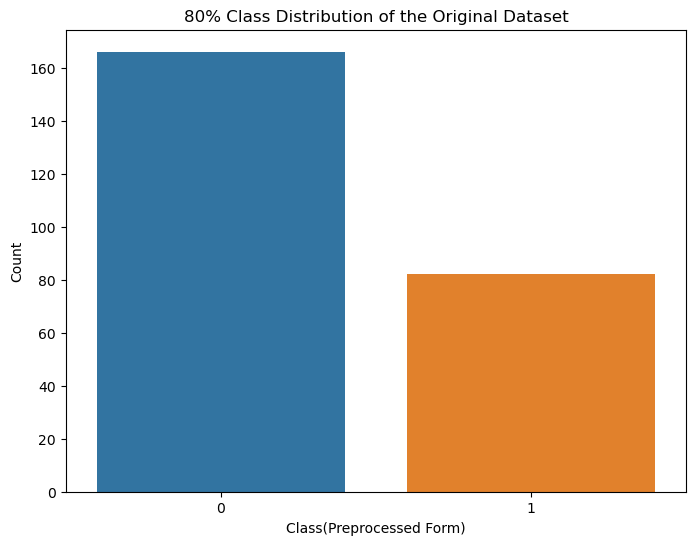

In [33]:
import matplotlib.pyplot as plt
# Assuming 'Class_att' is your target column
class_counts = lowerBackPain_train_dataframe['Class_att'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class(Preprocessed Form)')
plt.ylabel('Count')
plt.title('80% Class Distribution of the Original Dataset')
plt.show()

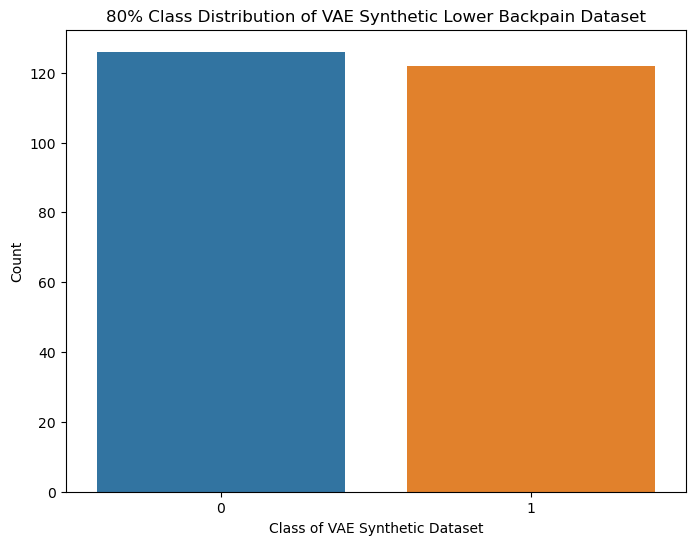

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# If ae_synthetic_labels_df is a DataFrame with a column named 'PredictedLabels'
plt.figure(figsize=(8, 6))
sns.countplot(x=vae_synthetic_labels_series, data=vae_synthetic_data_df)
plt.title('80% Class Distribution of VAE Synthetic Lower Backpain Dataset')
plt.xlabel('Class of VAE Synthetic Dataset')
plt.ylabel('Count')
plt.show()

# Computational and Graphical Representations of AUC-ROC Curves by Classifiers

C:\Users\Ede\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 99, number of negative: 99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

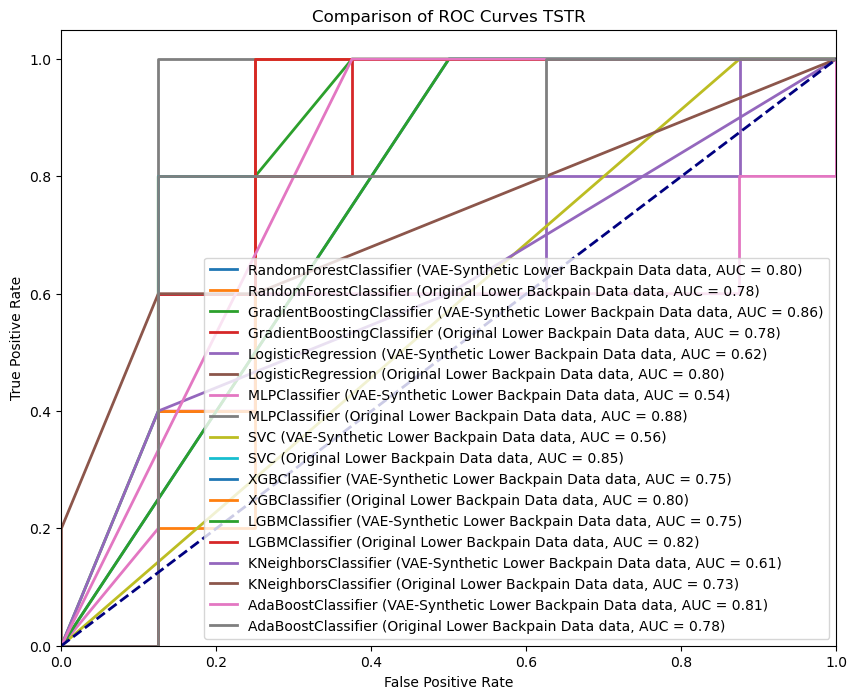

In [54]:
# 1. Import Necessary Libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 2. Define Data Splits for Original and Control Datasets
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(featuresCONT, labelsCONT, test_size=0.2, random_state=42)
X_train_syn_vae, X_test_syn_vae, y_train_syn_vae, y_test_syn_vae = train_test_split(featuresLBP, labelsLBP, test_size=0.2, random_state=42)

# 3. Scale the Data
scaler = StandardScaler()
X_train_syn_vae_scaled = scaler.fit_transform(X_train_syn_vae)
X_test_syn_vae_scaled = scaler.transform(X_test_syn_vae)
# X_train_cont_scaled = scaler.transform(X_train_cont)
X_test_cont_scaled = scaler.transform(X_test_cont)

# Assuming featuresAE and labelsAE are your synthetic dataset and its corresponding labels
X_original_scaled = scaler.transform(featuresLBP_ORIG)

# 4. Split and Scale the Synthetic Dataset
X_train_orig_scaled, X_test_orig_scaled, y_train_orig, y_test_orig = train_test_split(X_original_scaled, labelsLBP_ORIG, test_size=0.2, random_state=42)

# 5. Define the `plot_auc_roc` Function
def plot_auc_roc(model, X_train, y_train, X_test, y_test, data_type):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        raise AttributeError(f"{model.__class__.__name__} does not have predict_proba or decision_function.")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} ({data_type} data, AUC = {roc_auc:.2f})')

    # 6. Define Models
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(),
    "SVC": SVC(probability=True),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier()
}
# 7. Plot AUC-ROC Curves for Models Trained on Synthetic and Real Data
plt.figure(figsize=(10, 8))
for name, model in models.items():
    plot_auc_roc(model, X_train_syn_vae_scaled, y_train_syn_vae, X_test_cont_scaled, y_test_cont, "VAE-Synthetic Lower Backpain Data") #TSTR
    plot_auc_roc(model, X_train_orig_scaled, y_train_orig, X_test_cont_scaled, y_test_cont, "Original Lower Backpain Data") #TRTR
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves TSTR')
plt.legend(loc="lower right")
plt.show()


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 62, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313131 -> initscore=-0.785521
[LightGBM] [Info] Start training from score -0.785521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

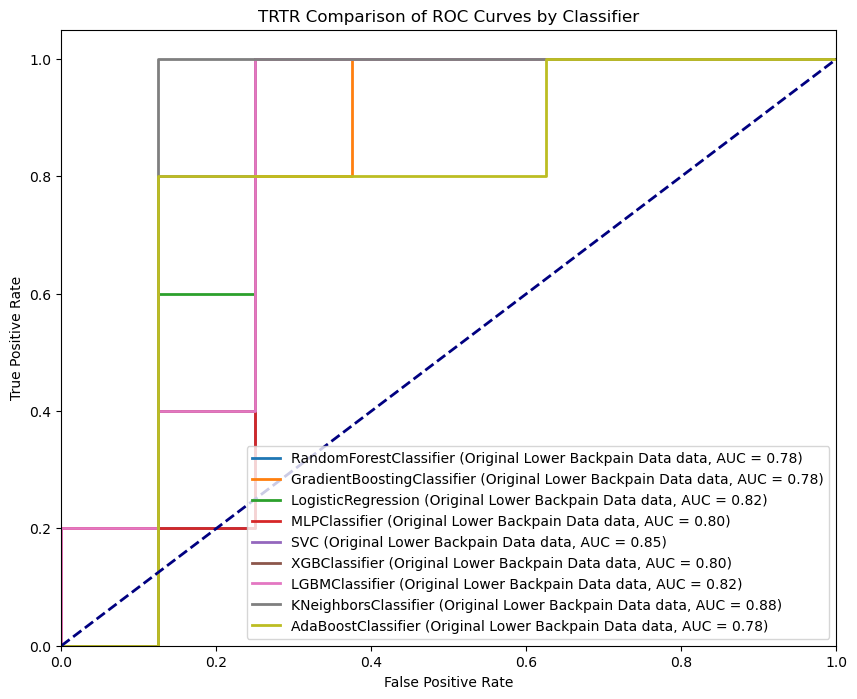

In [47]:
# 1. Import Necessary Libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 2. Define Data Splits for Original Dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(featuresLBP_ORIG, labelsLBP_ORIG, test_size=0.2, random_state=42)
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(featuresCONT, labelsCONT, test_size=0.2, random_state=42)



# 3. Scale the Data
scaler = StandardScaler()
X_train_orig_scaled = scaler.fit_transform(X_train_orig)
X_test_cont_scaled = scaler.transform(X_test_cont)

# 5. Define the `plot_auc_roc` Function
def plot_auc_roc(model, X_train, y_train, X_test, y_test, data_type):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        raise AttributeError(f"{model.__class__.__name__} does not have predict_proba or decision_function.")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} ({data_type} data, AUC = {roc_auc:.2f})')

# 6. Define Models
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(),
    "SVC": SVC(probability=True),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

# 7. Plot AUC-ROC Curves for Models Trained on Original Data
plt.figure(figsize=(10, 8))
for name, model in models.items():
    plot_auc_roc(model, X_train_orig_scaled, y_train_orig, X_test_cont_scaled, y_test_cont, "Original Lower Backpain Data") #TRTR

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TRTR Comparison of ROC Curves by Classifier')
plt.legend(loc="lower right")
plt.show()

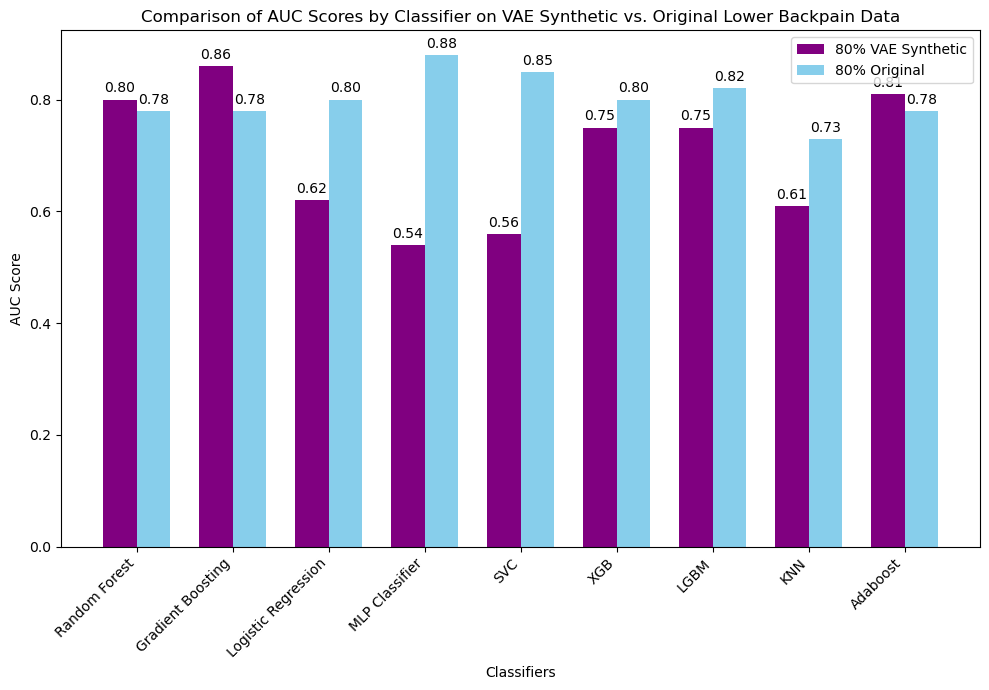

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names
classifiers = [
    "Random Forest", "Gradient Boosting", "Logistic Regression", 
    "MLP Classifier", "SVC", "XGB", "LGBM", "KNN", "Adaboost"
]

# AUC scores for synthetic data
synthetic_auc = [0.80, 0.86, 0.62, 0.54, 0.56, 0.75, 0.75, 0.61, 0.81]

# AUC scores for original data
original_auc = [0.78, 0.78, 0.80, 0.88, 0.85, 0.80, 0.82, 0.73, 0.78]

x = np.arange(len(classifiers))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, synthetic_auc, width, label='80% VAE Synthetic', color='purple')# navy
rects2 = ax.bar(x + width/2, original_auc, width, label='80% Original', color='skyblue')# skyblue

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('AUC Score')
ax.set_title('Comparison of AUC Scores by Classifier on VAE Synthetic vs. Original Lower Backpain Data')
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()


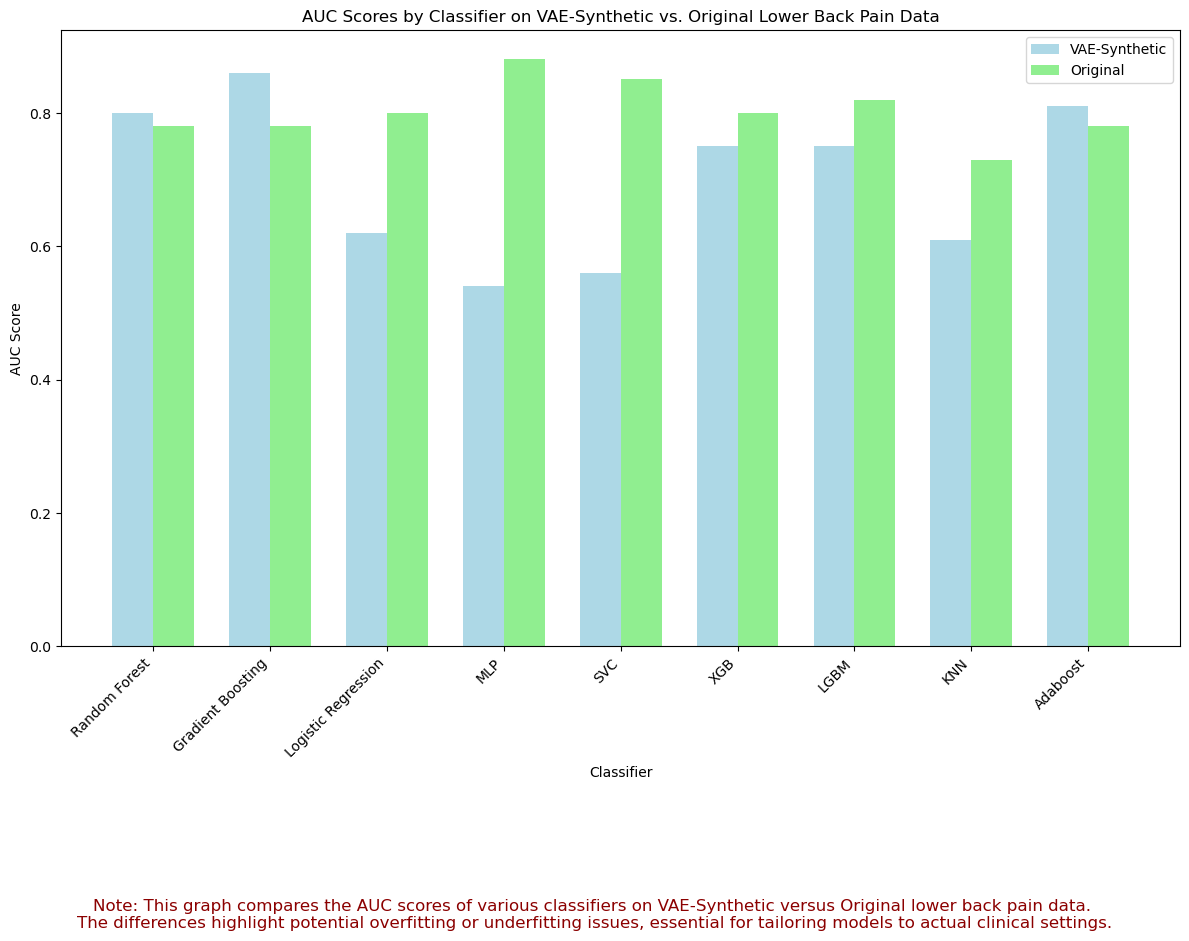

In [80]:
# Data from the updated results
data_updated = {
    'Classifier': ['Random Forest', 'Gradient Boosting', 'Logistic Regression',
                   'MLP', 'SVC', 'XGB', 'LGBM', 'KNN', 'Adaboost'],
    'VAE-Synthetic': [0.80, 0.86, 0.62, 0.54, 0.56, 0.75, 0.75, 0.61, 0.81],
    'Original': [0.78, 0.78, 0.80, 0.88, 0.85, 0.80, 0.82, 0.73, 0.78]
}

# Create DataFrame
df_updated = pd.DataFrame(data_updated)

# Set the positions and width for the bars
pos_updated = np.arange(len(df_updated['Classifier']))
width_updated = 0.35

# Plotting the bars
fig_updated, ax_updated = plt.subplots(figsize=(12, 8))

bar1_updated = ax_updated.bar(pos_updated - width_updated/2, df_updated['VAE-Synthetic'], width_updated, label='VAE-Synthetic', color='lightblue')
bar2_updated = ax_updated.bar(pos_updated + width_updated/2, df_updated['Original'], width_updated, label='Original', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_updated.set_xlabel('Classifier')
ax_updated.set_ylabel('AUC Score')
ax_updated.set_title('AUC Scores by Classifier on VAE-Synthetic vs. Original Lower Back Pain Data')
ax_updated.set_xticks(pos_updated)
ax_updated.set_xticklabels(df_updated['Classifier'], rotation=45, ha="right")
ax_updated.legend()

# Adding a custom note
note_updated = '''Note: This graph compares the AUC scores of various classifiers on VAE-Synthetic versus Original lower back pain data. 
The differences highlight potential overfitting or underfitting issues, essential for tailoring models to actual clinical settings.'''

fig_updated.text(0.5, -0.15, note_updated, ha='center', va='center', fontsize=12, color='darkred')

plt.tight_layout()
plt.show()


# CLASSIFICATION REPORTS FOR 80% VAE SYNTHETIC AND ORIGINAL LOWER BACKPAIN DATASET

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = GradientBoostingClassifier(random_state=42)
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # this is the 20% unseen data TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("GB on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = GradientBoostingClassifier(random_state=42)
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # this is the 20% unseen data TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("GB on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


GB on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.67      0.40      0.50         5

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13

GB on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.67      0.80      0.73         5

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13



In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = RandomForestClassifier(random_state=42)
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("RF on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = RandomForestClassifier(random_state=42)
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("RF on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


RF on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.50      0.20      0.29         5

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13

RF on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.62      1.00      0.77         5

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13



In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = XGBClassifier()
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("XGB on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = XGBClassifier()
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("XGB on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


XGB on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.50      0.40      0.44         5

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13

XGB on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.56      1.00      0.71         5

    accuracy                           0.69        13
   macro avg       0.78      0.75      0.69        13
weighted avg       0.83      0.69      0.68        13



In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = MLPClassifier()
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("MLP on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = MLPClassifier()
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("MLP on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


MLP on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.50      0.20      0.29         5

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13

MLP on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.50      1.00      0.67         5

    accuracy                           0.62        13
   macro avg       0.75      0.69      0.61        13
weighted avg       0.81      0.62      0.59        13



C:\Users\Ede\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = DecisionTreeClassifier()
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("DCT on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = DecisionTreeClassifier()
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("DCT on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


DCT on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.20      0.33         5

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13

DCT on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.62      1.00      0.77         5

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13



In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = LogisticRegression(C=1.0, solver='lbfgs', random_state=42, max_iter=1500)
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("LGR on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = LogisticRegression(C=1.0, solver='lbfgs', random_state=42, max_iter=1500)
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("LGR on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


LGR on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.60      0.60      0.60         5

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13

LGR on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.62      1.00      0.77         5

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13



In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = KNeighborsClassifier()
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # this is the 20% unseen data TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("KNN on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = KNeighborsClassifier()
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # this is the 20% unseen data TSTR 

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("KNN on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


KNN on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.67      0.80      0.73         5

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13

KNN on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.62      1.00      0.77         5

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13



In [69]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = LGBMClassifier()
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("LGBM on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = LGBMClassifier()
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("LGBM on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


[LightGBM] [Info] Number of positive: 62, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313131 -> initscore=-0.785521
[LightGBM] [Info] Start training from score -0.785521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [70]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = SVC(probability=True)
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("SVC on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = SVC(probability=True)
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("SVC on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


SVC on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.50      0.40      0.44         5

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13

SVC on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.62      1.00      0.77         5

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13



In [77]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# Adjusting model complexity by limiting the depth
classifier_orig = AdaBoostClassifier()
classifier_orig.fit(X_train_orig, y_train_orig)

# Predicting on the test set
y_pred = classifier_orig.predict(X_test_cont) # TRTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred, digits=2)
print("AdaBoost on 80% Original BackPain/Tested on 20% Control Data (TRTR):\n", report)


# Adjusting model complexity by limiting the depth
classifier_syn = AdaBoostClassifier()
classifier_syn.fit(X_train_syn_vae, y_train_syn_vae)


# Predicting on the test set
y_pred1 = classifier_syn.predict(X_test_cont) # TSTR

# Generating the classification report
report = classification_report(y_test_cont, y_pred1, digits=2)
print("AdaBoost on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):\n", report)


AdaBoost on 80% Original BackPain/Tested on 20% Control Data (TRTR):
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13

AdaBoost on 80% VAE Synthetic BackPain/Tested on 20% Control Data (TSTR):
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.56      1.00      0.71         5

    accuracy                           0.69        13
   macro avg       0.78      0.75      0.69        13
weighted avg       0.83      0.69      0.68        13



C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


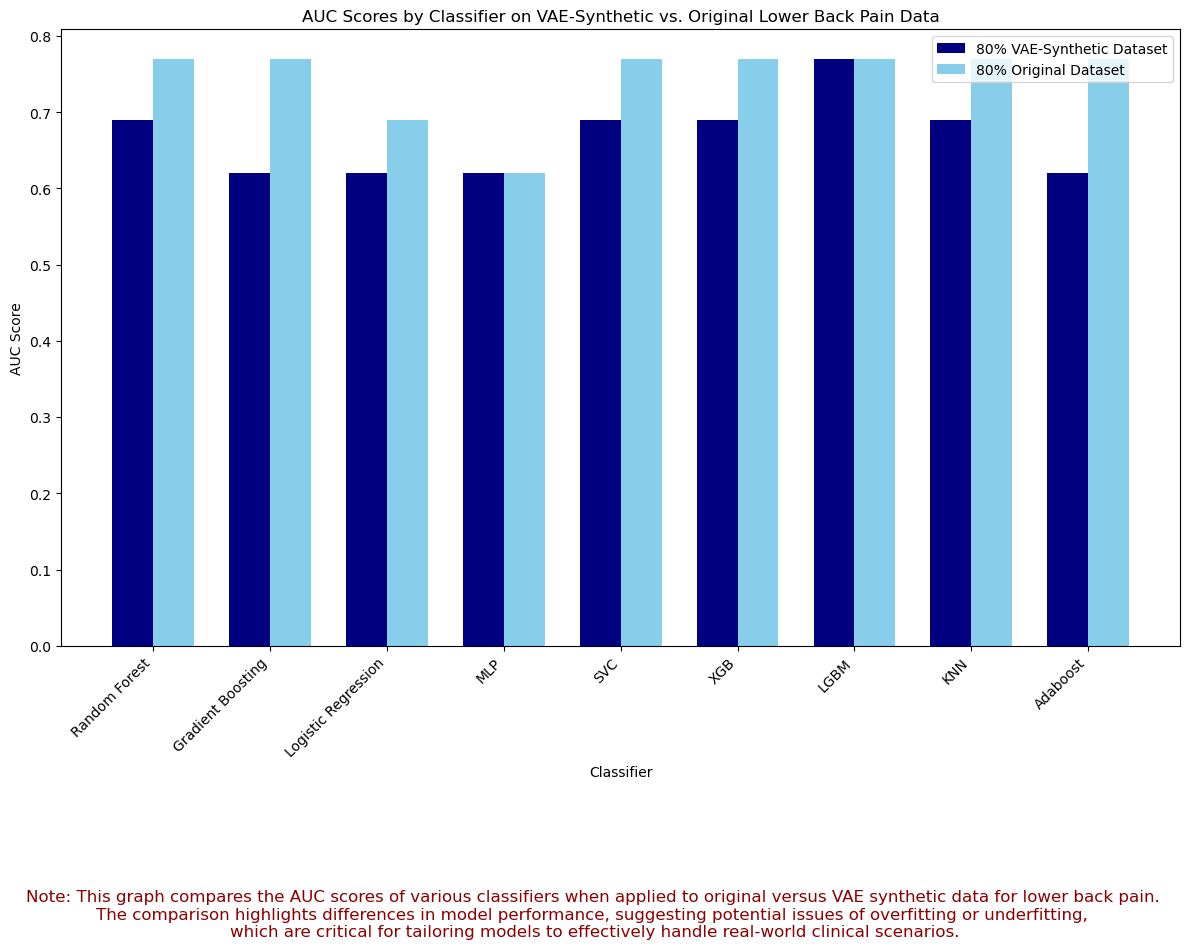

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data from the updated results
data_updated = {
    'Classifier': ['Random Forest', 'Gradient Boosting', 'Logistic Regression',
                   'MLP', 'SVC', 'XGB', 'LGBM', 'KNN', 'Adaboost'],
    'VAE-Synthetic': [0.69, 0.62, 0.62, 0.62, 0.69, 0.69, 0.77, 0.69, 0.62],
    'Original': [0.77, 0.77, 0.69, 0.62, 0.77, 0.77, 0.77, 0.77, 0.77]
}

# Create DataFrame
df_updated = pd.DataFrame(data_updated)

# Set the positions and width for the bars
pos_updated = np.arange(len(df_updated['Classifier']))
width_updated = 0.35

# Plotting the bars
fig_updated, ax_updated = plt.subplots(figsize=(12, 8))

bar1_updated = ax_updated.bar(pos_updated - width_updated/2, df_updated['VAE-Synthetic'], width_updated, label='80% VAE-Synthetic Dataset', color='navy')
bar2_updated = ax_updated.bar(pos_updated + width_updated/2, df_updated['Original'], width_updated, label='80% Original Dataset', color='skyblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax_updated.set_xlabel('Classifier')
ax_updated.set_ylabel('AUC Score')
ax_updated.set_title('AUC Scores by Classifier on VAE-Synthetic vs. Original Lower Back Pain Data')
ax_updated.set_xticks(pos_updated)
ax_updated.set_xticklabels(df_updated['Classifier'], rotation=45, ha="right")
ax_updated.legend()

def autolabel(rects):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_updated.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



# Adding a custom note
note_updated = '''Note: This graph compares the AUC scores of various classifiers when applied to original versus VAE synthetic data for lower back pain. 
The comparison highlights differences in model performance, suggesting potential issues of overfitting or underfitting, 
which are critical for tailoring models to effectively handle real-world clinical scenarios.'''

fig_updated.text(0.5, -0.15, note_updated, ha='center', va='center', fontsize=12, color='darkred')

plt.tight_layout()
plt.show()


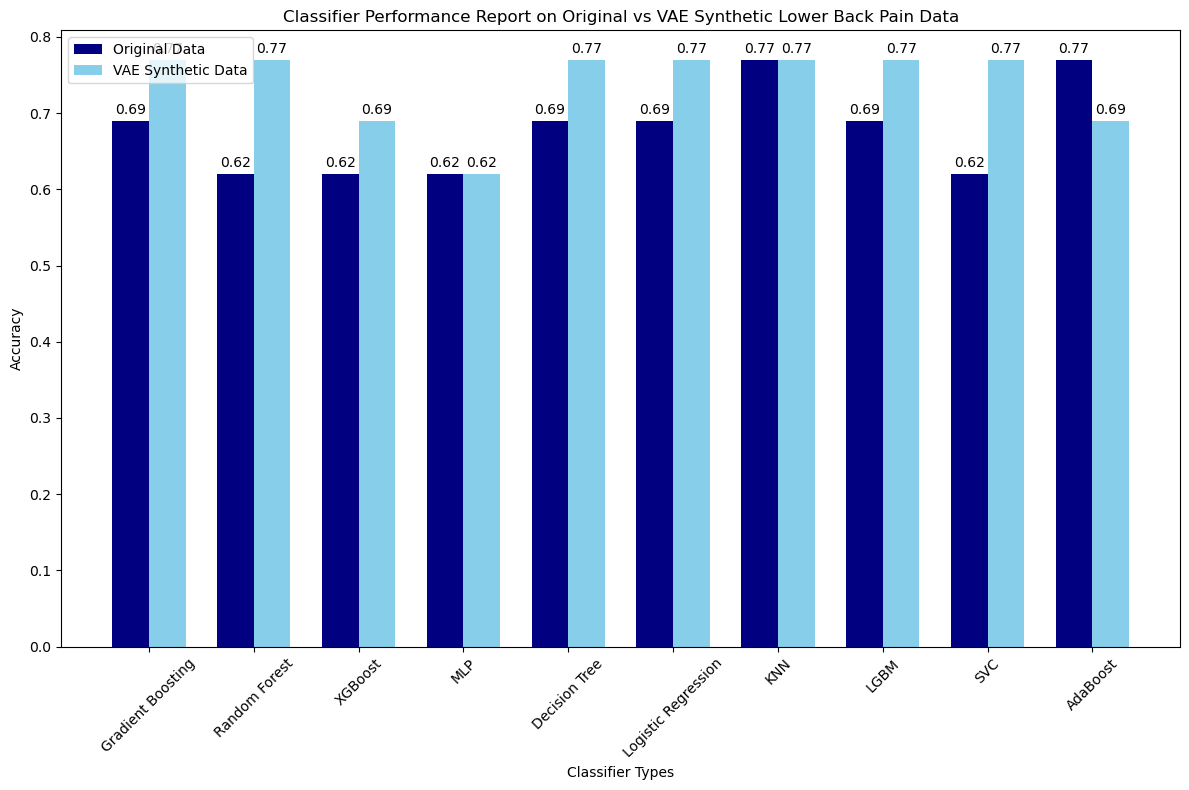

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names and their performance metrics
classifiers = ['Gradient Boosting', 'Random Forest', 'XGBoost', 'MLP', 'Decision Tree', 
               'Logistic Regression', 'KNN', 'LGBM', 'SVC', 'AdaBoost']
original_accuracy = [0.69, 0.62, 0.62, 0.62, 0.69, 0.69, 0.77, 0.69, 0.62, 0.77]
synthetic_accuracy = [0.77, 0.77, 0.69, 0.62, 0.77, 0.77, 0.77, 0.77, 0.77, 0.69]

x = np.arange(len(classifiers))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, original_accuracy, width, label='Original Data', color='navy')
rects2 = ax.bar(x + width/2, synthetic_accuracy, width, label='VAE Synthetic Data', color='skyblue')

# Adding labels, title and custom x-axis tick labels
ax.set_xlabel('Classifier Types')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Performance Report on Original vs VAE Synthetic Lower Back Pain Data')
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=45)
ax.legend()

# Adding text labels
def autolabel(rects):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


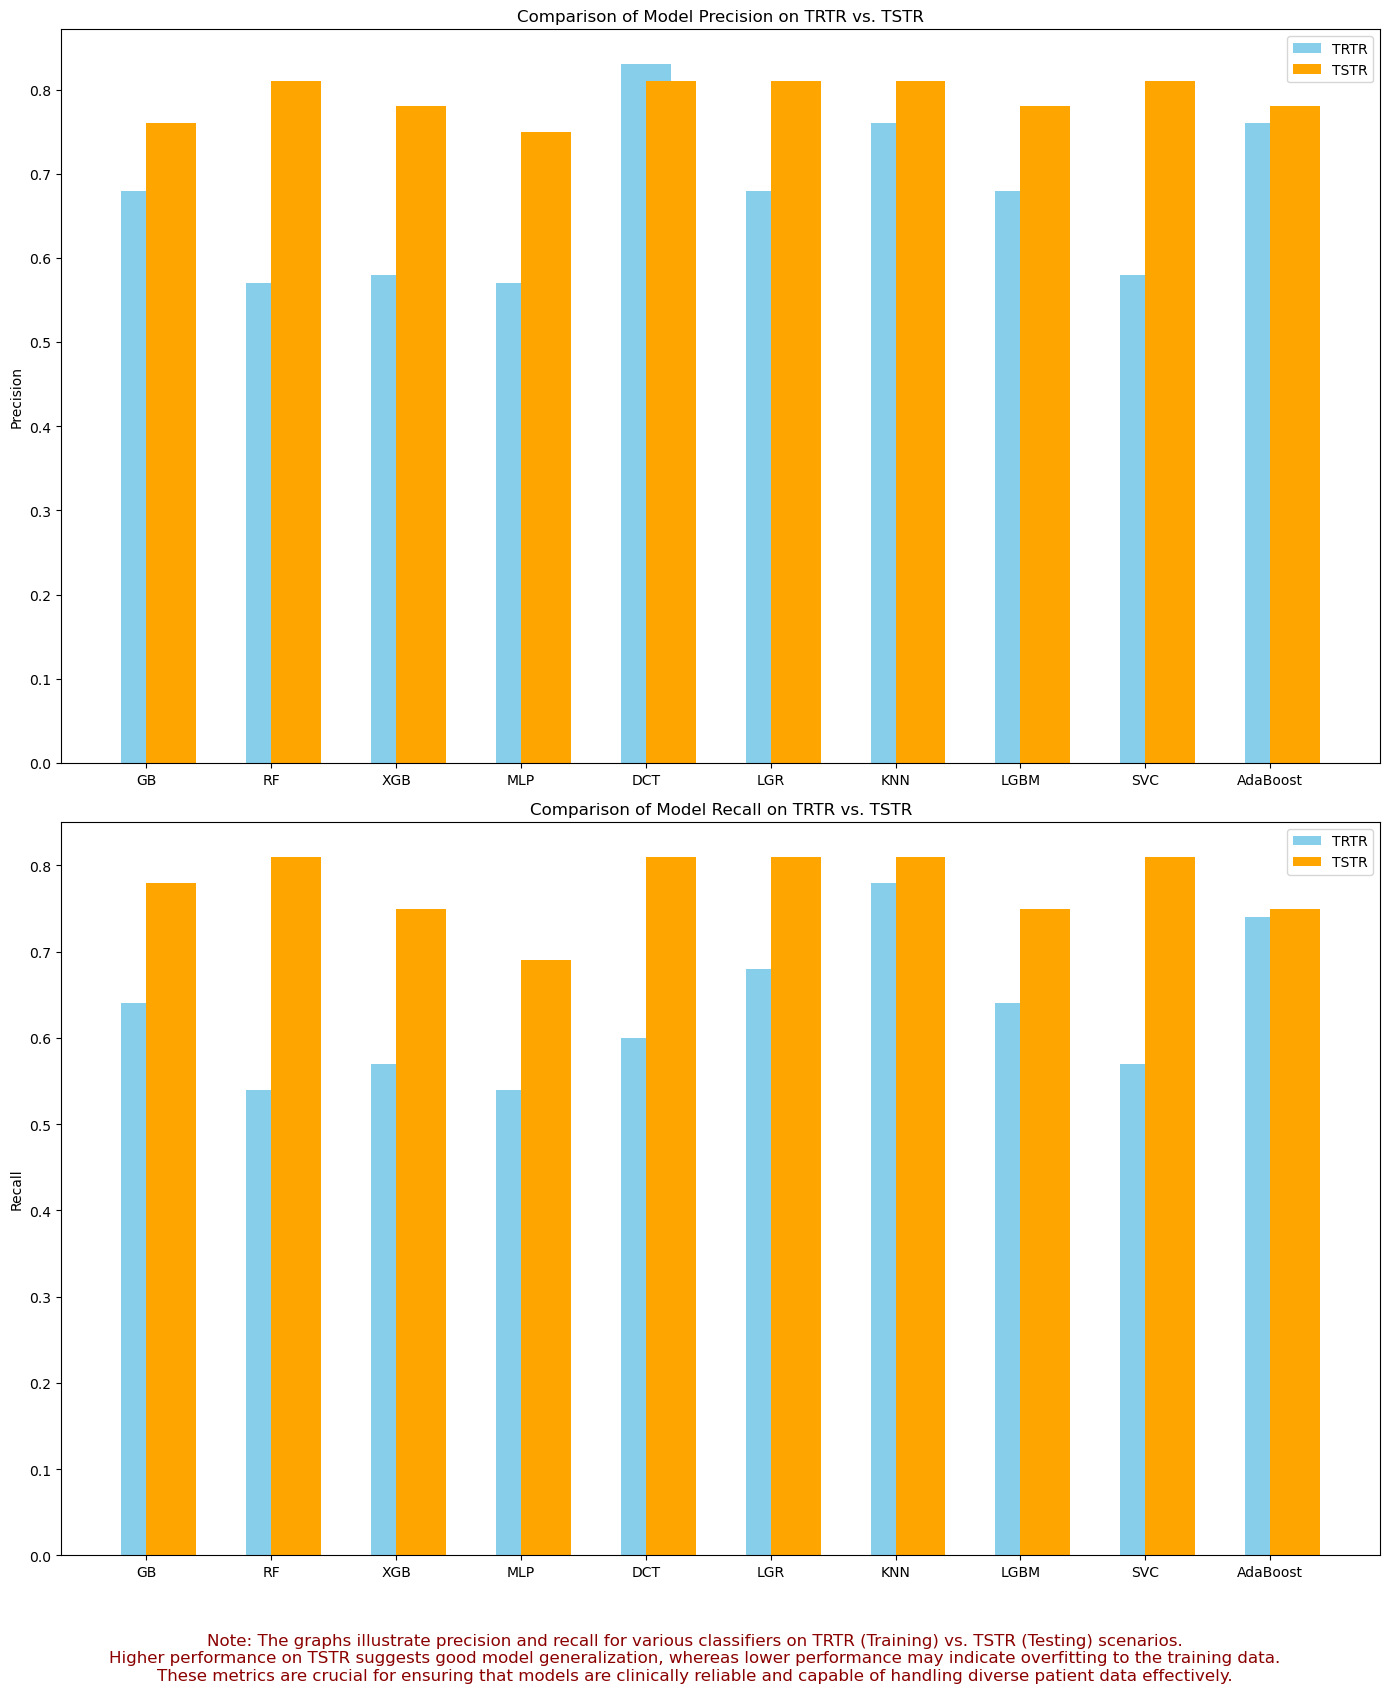

In [93]:
# Creating a DataFrame to hold the precision and recall data from the classification reports
classifier_data = {
    "Classifier": ["GB", "RF", "XGB", "MLP", "DCT", "LGR", "KNN", "LGBM", "SVC", "AdaBoost"],
    "Precision_TRTR": [0.68, 0.57, 0.58, 0.57, 0.83, 0.68, 0.76, 0.68, 0.58, 0.76],
    "Precision_TSTR": [0.76, 0.81, 0.78, 0.75, 0.81, 0.81, 0.81, 0.78, 0.81, 0.78],
    "Recall_TRTR": [0.64, 0.54, 0.57, 0.54, 0.60, 0.68, 0.78, 0.64, 0.57, 0.74],
    "Recall_TSTR": [0.78, 0.81, 0.75, 0.69, 0.81, 0.81, 0.81, 0.75, 0.81, 0.75]
}

df_classifier_data = pd.DataFrame(classifier_data)

# Plotting the data
fig, ax = plt.subplots(2, 1, figsize=(14, 16))

# Precision bars
ax[0].bar(df_classifier_data["Classifier"], df_classifier_data["Precision_TRTR"], width=0.4, label="TRTR", color='skyblue', align='center')
ax[0].bar(df_classifier_data["Classifier"], df_classifier_data["Precision_TSTR"], width=0.4, label="TSTR", color='orange', align='edge')

ax[0].set_ylabel('Precision')
ax[0].set_title('Comparison of Model Precision on TRTR vs. TSTR')
ax[0].legend()

# Recall bars
ax[1].bar(df_classifier_data["Classifier"], df_classifier_data["Recall_TRTR"], width=0.4, label="TRTR", color='skyblue', align='center')
ax[1].bar(df_classifier_data["Classifier"], df_classifier_data["Recall_TSTR"], width=0.4, label="TSTR", color='orange', align='edge')

ax[1].set_ylabel('Recall')
ax[1].set_title('Comparison of Model Recall on TRTR vs. TSTR')
ax[1].legend()

# Adding a note
note_graph = '''Note: The graphs illustrate precision and recall for various classifiers on TRTR (Training) vs. TSTR (Testing) scenarios.
Higher performance on TSTR suggests good model generalization, whereas lower performance may indicate overfitting to the training data.
These metrics are crucial for ensuring that models are clinically reliable and capable of handling diverse patient data effectively.'''

fig.text(0.5, -0.04, note_graph, ha='center', va='center', fontsize=12, color='darkred')

plt.tight_layout()
plt.show()


# COMPUTING CROSS-VALIDATION OF 80% ORIGINAL AND VAE-SYNTHETIC LOWER BACKPAIN

In [ ]:
vae_synthetic_data_df.head())
print(vae_synthetic_labels_series.head())
X_train_syn_vae, X_test_syn_vae, y_train_syn_vae, y_test_syn_vae = train_test_split(vae_synthetic_data_df, vae_synthetic_labels_series, test_size=0.2, random_state=42)
vae_synthetic_backpain_data_with_labels_df

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Encoding categorical labels if necessary
le = LabelEncoder()
vae_synthetic_labels_vae_encoded = le.fit_transform(vae_synthetic_labels_series)

# Splitting the dataset
X_train_syn_vae, X_test_syn_vae, y_train_syn_vae, y_test_syn_vae = train_test_split(vae_synthetic_data_df, vae_synthetic_labels_vae_encoded, test_size=0.2, random_state=42)

# List of classifiers to evaluate
classifiers = [
    DecisionTreeClassifier(random_state=2),
    GradientBoostingClassifier(random_state=2),
    RandomForestClassifier(n_estimators=100, random_state=2),
    AdaBoostClassifier(random_state=2),
    LGBMClassifier(random_state=2),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2),
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000, random_state=2),
    SVC(random_state=2),
    MLPClassifier(max_iter=1000, random_state=2)
]

# Evaluate each classifier
for clf in classifiers:
    cv_scores = cross_val_score(clf, X_train_syn_vae, y_train_syn_vae, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    print(f"{clf.__class__.__name__}: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = {mean_cv_score:.4f}, Std = {std_cv_score:.4f}")


DecisionTreeClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
GradientBoostingClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
RandomForestClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
AdaBoostClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
[LightGBM] [Info] Number of positive: 79, number of negative: 79
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 158, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anacond

XGBClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 0.9950, Std = 0.0100
KNeighborsClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
LogisticRegression: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
SVC: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000
MLPClassifier: Mean CV Accuracy of 80% VAE-Synthetic Lower Backpain = 1.0000, Std = 0.0000


In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Assuming final_synthetic_df and final_synthetic_labels are your features and labels DataFrames
# Encoding categorical labels if necessary
le = LabelEncoder()
original_labels_orig_encoded = le.fit_transform(labelsLBP_ORIG)


# Proceed with your original process by Splitting the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(featuresLBP_ORIG, original_labels_orig_encoded, test_size=0.2, random_state=42)


# List of classifiers to evaluate
classifiers = [
    DecisionTreeClassifier(random_state=2),
    GradientBoostingClassifier(random_state=2),
    RandomForestClassifier(n_estimators=100, random_state=2),
    AdaBoostClassifier(random_state=2),
    LGBMClassifier(random_state=2),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2),
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000, random_state=2),
    SVC(random_state=2),
    MLPClassifier(max_iter=1000, random_state=2)
]

# Evaluate each classifier
for clf in classifiers:
    cv_scores = cross_val_score(clf, X_train_orig, y_train_orig, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    print(f"{clf.__class__.__name__}: Mean CV Accuracy of 80% Original Lower Backpain= {mean_cv_score:.4f}, Std = {std_cv_score:.4f}")


DecisionTreeClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.7883, Std = 0.0612
GradientBoostingClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.8382, Std = 0.0214
RandomForestClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.8183, Std = 0.0234


C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Ede\anacond

AdaBoostClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.8437, Std = 0.0322
[LightGBM] [Info] Number of positive: 49, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 158, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310127 -> initscore=-0.799528
[LightGBM] [Info] Start training from score -0.799528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

XGBClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.8336, Std = 0.0328
KNeighborsClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.8229, Std = 0.0247
LogisticRegression: Mean CV Accuracy of 80% Original Lower Backpain= 0.8087, Std = 0.0632
SVC: Mean CV Accuracy of 80% Original Lower Backpain= 0.8235, Std = 0.0439
MLPClassifier: Mean CV Accuracy of 80% Original Lower Backpain= 0.6415, Std = 0.0524


# GRAPHICAL REPRESENTATION OF THE ABOVE MEAN CV OF ORIGINAL AND SYNTHETIC DATASETS

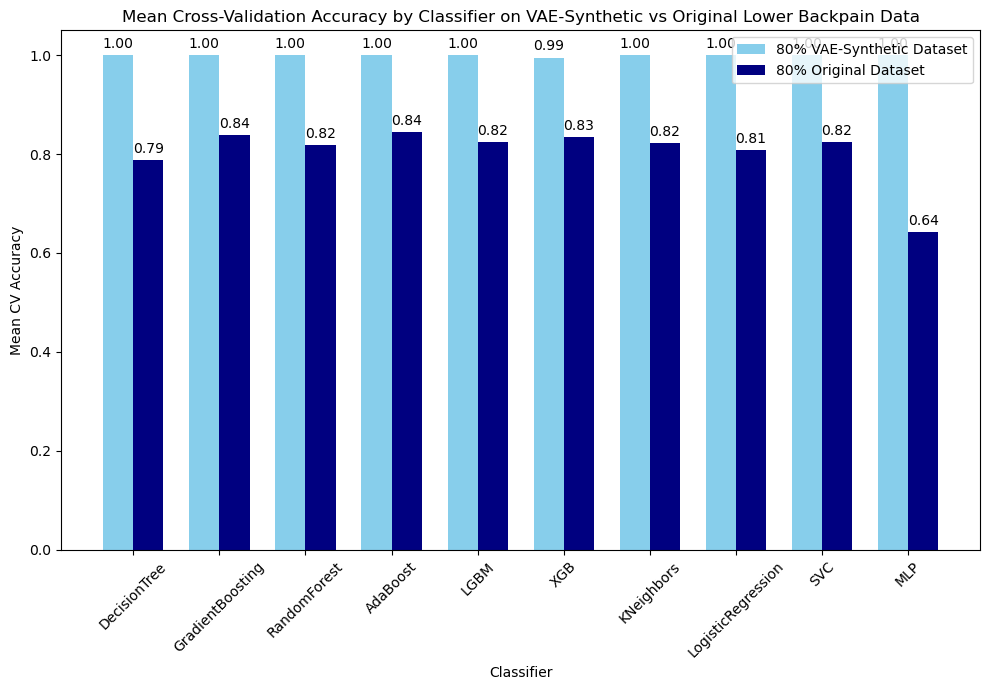

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Classifier names
classifiers = ['DecisionTree', 'GradientBoosting', 'RandomForest', 'AdaBoost', 'LGBM', 'XGB', 'KNeighbors', 'LogisticRegression', 'SVC', 'MLP']

# Mean CV accuracies for AE-Synthetic Lower Backpain
synthetic_accuracies = [1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0]

# Mean CV accuracies for Original Lower Backpain
original_accuracies = [0.7883, 0.8382, 0.8183, 0.8437, 0.8235, 0.8336, 0.8229, 0.8087, 0.8235, 0.6415]

x = np.arange(len(classifiers))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, synthetic_accuracies, width, label='80% VAE-Synthetic Dataset', color='skyblue')
rects2 = ax.bar(x + width/2, original_accuracies, width, label='80% Original Dataset', color='navy')

# Add text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Mean CV Accuracy')
ax.set_xlabel('Classifier')
ax.set_title('Mean Cross-Validation Accuracy by Classifier on VAE-Synthetic vs Original Lower Backpain Data')
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=45)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.show()


# Computing Numerical Statistical Values: KS-Test, P-Value, MSE, RMSE, MAE, F-Test for Variances, T-Test for Means

In [75]:
 from scipy.stats import ks_2samp, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming `obesity_df` and `ae_synthetic_data_df` are properly aligned
for column in vae_synthetic_backpain_data_with_labels_df.columns:
    # KS Test and P-Value
    ks_stat, ks_pvalue = ks_2samp(lowerBackPain_train_dataframe[column], vae_synthetic_backpain_data_with_labels_df[column])
    print(f"KS-Test for {column}: Stat={ks_stat}, P-Value={ks_pvalue}")
    
    # MSE, RMSE, and MAE for a column
    mse = mean_squared_error(lowerBackPain_train_dataframe[column], vae_synthetic_backpain_data_with_labels_df[column])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(lowerBackPain_train_dataframe[column], vae_synthetic_backpain_data_with_labels_df[column])
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
    
    # F-Test and T-Test for comparing variances and means
    f_stat, f_pvalue = f_oneway(lowerBackPain_train_dataframe[column], vae_synthetic_backpain_data_with_labels_df[column])
    t_stat, t_pvalue = ttest_ind(lowerBackPain_train_dataframe[column], vae_synthetic_backpain_data_with_labels_df[column])
    print(f"F-Test: Stat={f_stat}, P-Value={f_pvalue}")
    print(f"T-Test: Stat={t_stat}, P-Value={t_pvalue}")

    # Means and Standard Deviation
    orig_mean = lowerBackPain_train_dataframe[column].mean()
    vae_syn_mean = vae_synthetic_backpain_data_with_labels_df[column].mean()
    orig_std = lowerBackPain_train_dataframe[column].std()
    vae_syn_std = vae_synthetic_backpain_data_with_labels_df[column].std()
    print(f"Original Mean={orig_mean}, VAE_Synthetic Mean={vae_syn_mean}, Original Std={orig_std}, VAE_Synthetic Std={vae_syn_std}\n")


KS-Test for pelvic_incidence: Stat=0.34274193548387094, P-Value=2.6040620134824596e-13
MSE: 359.4873106458793, RMSE: 18.960150596603373, MAE: 15.121192021161992
F-Test: Stat=5.117178000505222, P-Value=0.024123791455658777
T-Test: Stat=2.2621182167757627, P-Value=0.024123780091485806
Original Mean=59.914854344637135, VAE_Synthetic Mean=57.23241424560547, Original Std=17.037412780032998, VAE_Synthetic Std=7.6455864906311035

KS-Test for pelvic_tilt: Stat=0.27419354838709675, P-Value=1.305698242925471e-08
MSE: 110.34867050640632, RMSE: 10.504697544737132, MAE: 8.212806049171723
F-Test: Stat=1.5036742612298017, P-Value=0.22069106938330924
T-Test: Stat=1.2262432190336736, P-Value=0.22069134969779486
Original Mean=16.881647820282264, VAE_Synthetic Mean=16.06769371032715, Original Std=9.518624805401211, VAE_Synthetic Std=4.320254802703857

KS-Test for lumbar_lordosis_angle: Stat=0.3709677419354839, P-Value=1.4154609616773391e-15
MSE: 363.97663819921513, RMSE: 19.07817177297697, MAE: 15.018651

# Computing Graphical Statistical Values: KS-Test, P-Value, MSE, RMSE, MAE, F-Test for Variances, T-Test for Means

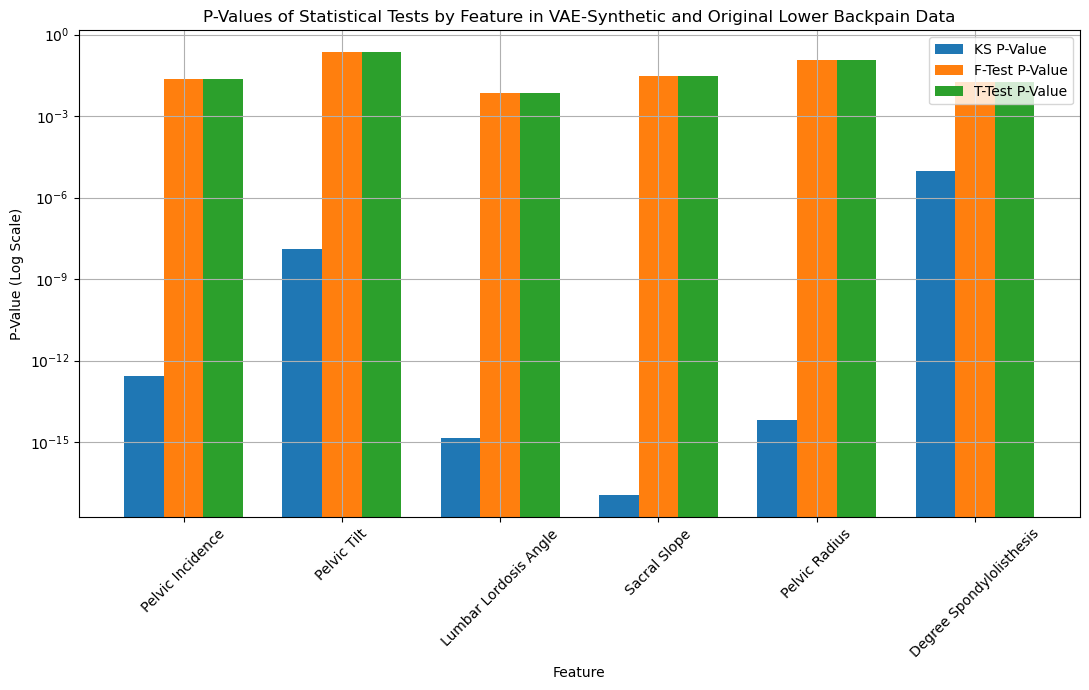

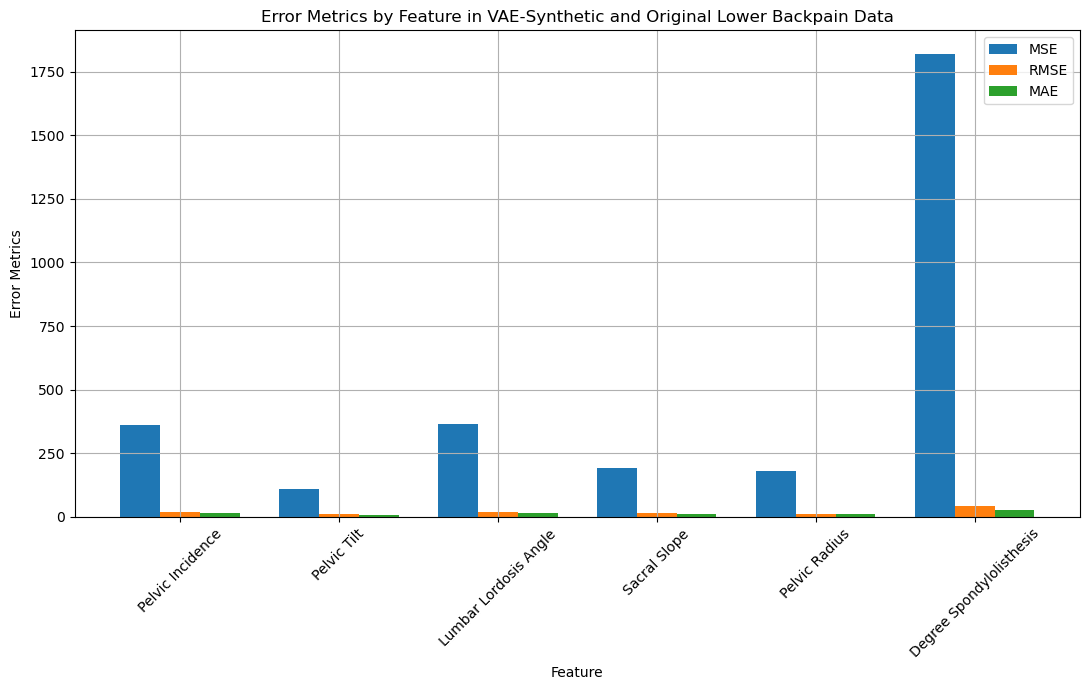

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Features and their respective values
features = [
    'Pelvic Incidence', 'Pelvic Tilt', 'Lumbar Lordosis Angle', 
    'Sacral Slope', 'Pelvic Radius', 'Degree Spondylolisthesis'
]

# Updated values from the text results provided
ks_pvalues = [
    2.6040620134824596e-13, 1.305698242925471e-08, 1.4154609616773391e-15, 
    1.1268306151704254e-17, 6.576877789362657e-15, 9.339491374182622e-06
]

f_pvalues = [
    0.024123791455658777, 0.22069106938330924, 0.007306789376943943, 
    0.030747009795747415, 0.11986129369000147, 0.018293643461313666
]

t_pvalues = [
    0.024123780091485806, 0.22069134969779486, 0.007306821135877818, 
    0.030747283169441274, 0.11986227380317348, 0.018293619008572074
]

# Error Metrics
mse_values = [
    359.4873106458793, 110.34867050640632, 363.97663819921513, 
    192.0029178356024, 179.77212984423937, 1820.9282173369772
]

rmse_values = [
    18.960150596603373, 10.504697544737132, 19.07817177297697, 
    13.856511748474158, 13.407912956319464, 42.67233550366065
]

mae_values = [
    15.121192021161992, 8.212806049171723, 15.018651879004695, 
    10.857846650776958, 10.07836546869369, 26.586828660316556
]

x = np.arange(len(features))  # the label locations
width = 0.25  # the width of the bars

# Plot for KS-Test P-Values
plt.figure(figsize=(11, 7))
plt.bar(x - width, ks_pvalues, width, label='KS P-Value')
plt.bar(x, f_pvalues, width, label='F-Test P-Value')
plt.bar(x + width, t_pvalues, width, label='T-Test P-Value')
plt.ylabel('P-Value (Log Scale)')
plt.yscale('log')  # Using log scale to better display very small p-values
plt.xlabel('Feature')
plt.title('P-Values of Statistical Tests by Feature in VAE-Synthetic and Original Lower Backpain Data')
plt.xticks(x, features, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Error Metrics
plt.figure(figsize=(11, 7))
plt.bar(x - width, mse_values, width, label='MSE')
plt.bar(x, rmse_values, width, label='RMSE')
plt.bar(x + width, mae_values, width, label='MAE')
plt.ylabel('Error Metrics')
plt.xlabel('Feature')
plt.title('Error Metrics by Feature in VAE-Synthetic and Original Lower Backpain Data')
plt.xticks(x, features, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



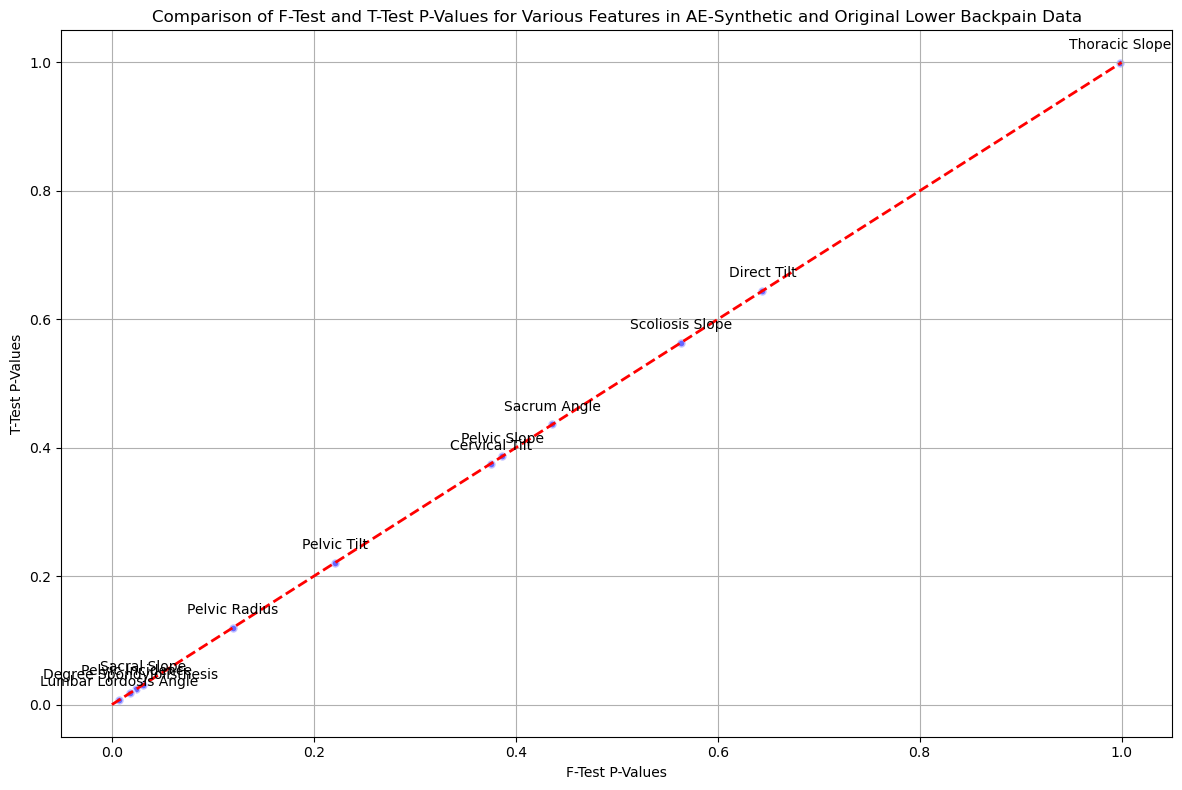

In [105]:
import matplotlib.pyplot as plt

# Data for the plot
features = [
    "Pelvic Incidence", "Pelvic Tilt", "Lumbar Lordosis Angle",
    "Sacral Slope", "Pelvic Radius", "Degree Spondylolisthesis",
    "Pelvic Slope", "Direct Tilt", "Thoracic Slope",
    "Cervical Tilt", "Sacrum Angle", "Scoliosis Slope"
]

f_test_pvalues = [0.0241, 0.2207, 0.0073, 0.0307, 0.1199, 0.0183, 0.3865, 0.6442, 0.9989, 0.3754, 0.4362, 0.5636]
t_test_pvalues = [0.0241, 0.2207, 0.0073, 0.0307, 0.1199, 0.0183, 0.3865, 0.6442, 0.9989, 0.3754, 0.4362, 0.5636]

# Plotting the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(f_test_pvalues, t_test_pvalues, color='blue', alpha=0.6, edgecolors='w', linewidths=2)

# Annotating the points
for i, txt in enumerate(features):
    plt.annotate(txt, (f_test_pvalues[i], t_test_pvalues[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Adding a line for perfect agreement
plt.plot([0, 1], [0, 1], 'r--', lw=2)

plt.title('Comparison of F-Test and T-Test P-Values for Various Features in AE-Synthetic and Original Lower Backpain Data')
plt.xlabel('F-Test P-Values')
plt.ylabel('T-Test P-Values')
plt.grid(True)
plt.tight_layout()


plt.show()


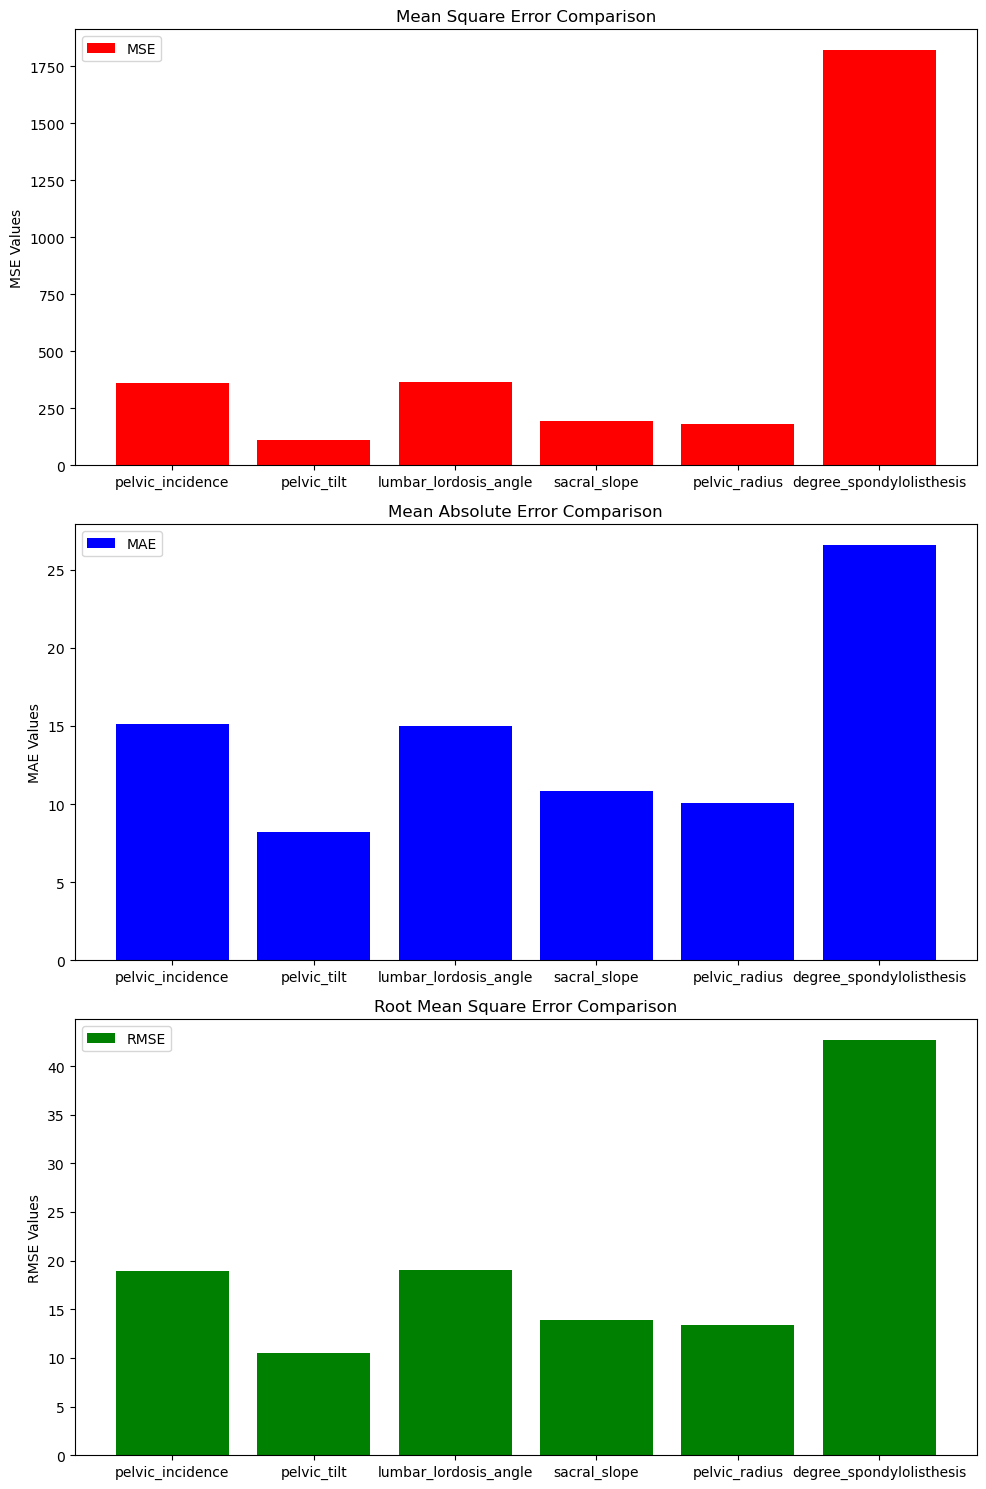

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
metrics = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
mse_values = [359.487, 110.348, 363.976, 192.003, 179.772, 1820.928]
mae_values = [15.121, 8.213, 15.019, 10.858, 10.078, 26.587]
rmse_values = [18.960, 10.505, 19.078, 13.857, 13.408, 42.672]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# MSE plot
ax[0].bar(metrics, mse_values, color='red', label='MSE')
ax[0].set_title('Mean Square Error Comparison')
ax[0].set_ylabel('MSE Values')
ax[0].legend()

# MAE plot
ax[1].bar(metrics, mae_values, color='blue', label='MAE')
ax[1].set_title('Mean Absolute Error Comparison')
ax[1].set_ylabel('MAE Values')
ax[1].legend()

# RMSE plot
ax[2].bar(metrics, rmse_values, color='green', label='RMSE')
ax[2].set_title('Root Mean Square Error Comparison')
ax[2].set_ylabel('RMSE Values')
ax[2].legend()


plt.tight_layout()
plt.show()


# CORRELATION HEATMAPS OF ORIGINAL AND VAE-SYNTHETIC LOWER BACKPAIN DATASET

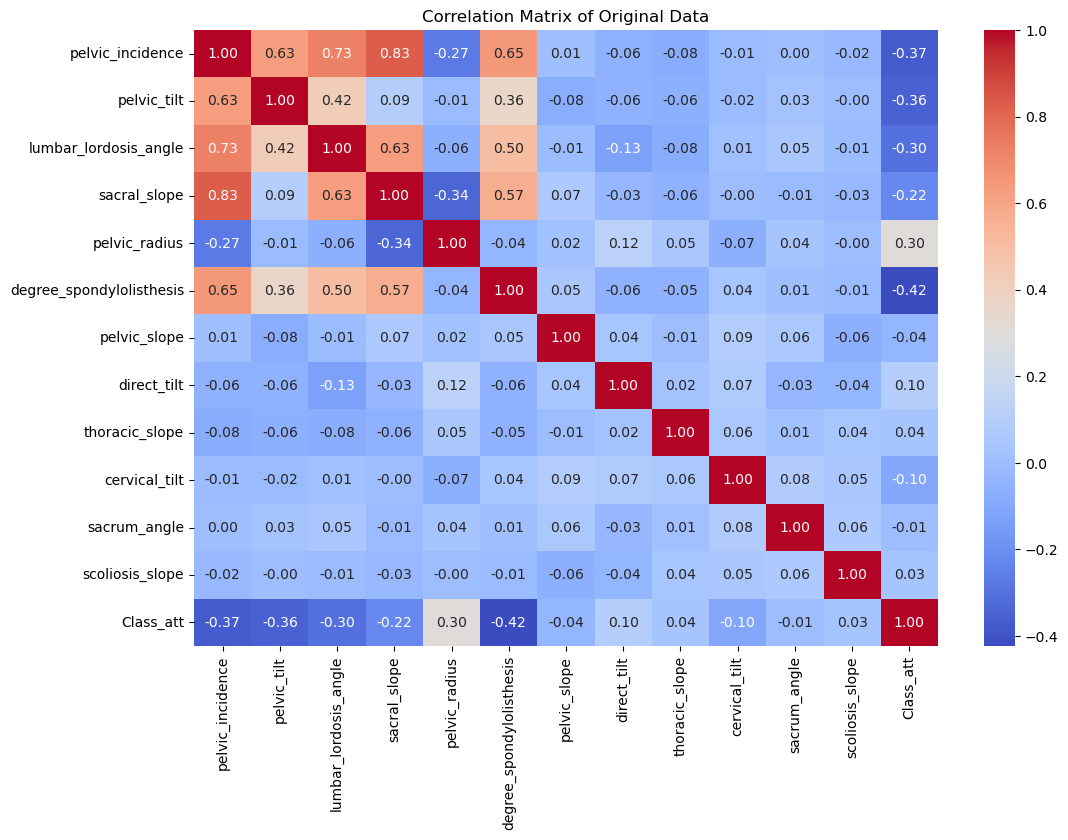

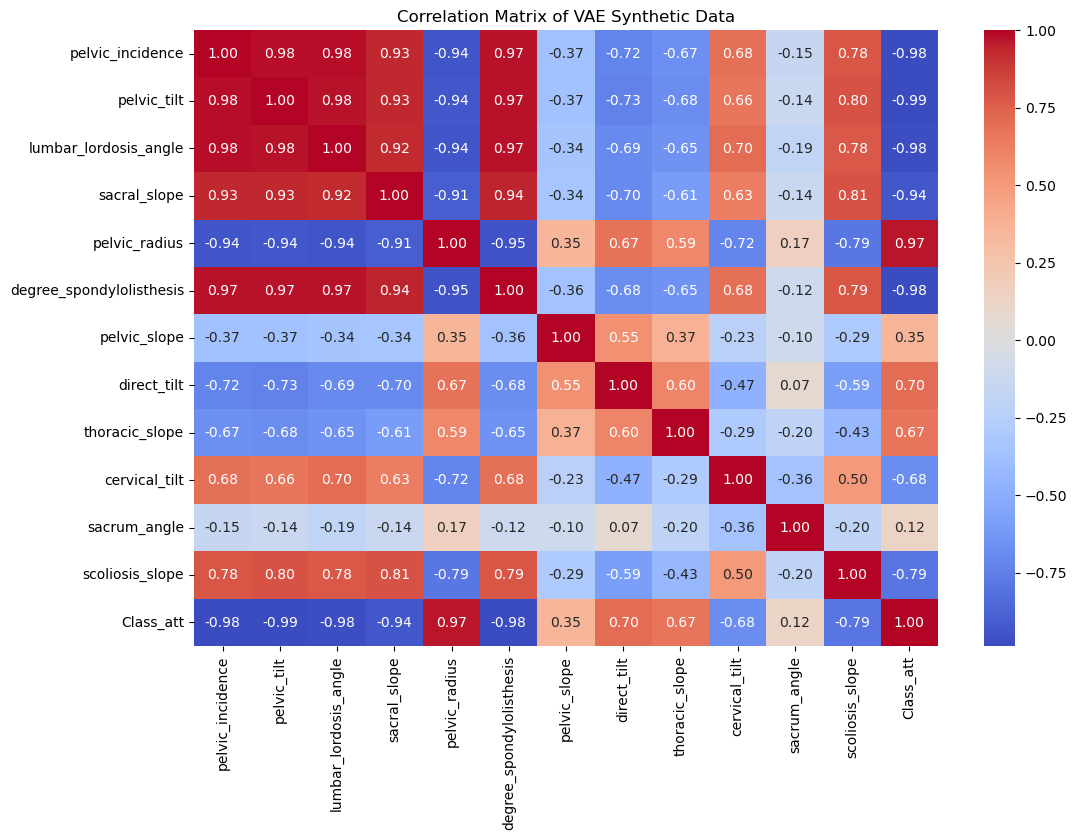

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_correlation_matrix(data, title):
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.show()

# Assuming X_train and ae_synthetic_data are your datasets
# Convert the numpy array of synthetic data into a DataFrame
# Ensure that ae_synthetic_data has the same number of features as X_train
# synthetic_df = pd.DataFrame(newest_ae_synthetic_data, columns=X_train.columns)

# Plot correlation matrix for original data
plot_correlation_matrix(lowerBackPain_train_dataframe , "Correlation Matrix of Original Data")

# Plot correlation matrix for synthetic data
plot_correlation_matrix(vae_synthetic_backpain_data_with_labels_df, "Correlation Matrix of VAE Synthetic Data")


# Computing Numerical Correlation Matrices of Original and Synthetic Datasets

In [106]:
# For the original dataset
print('80% Original Lower Backpain Numerical Correlation Matrix:')
print(lowerBackPain_train_dataframe.corr())

# For the AE synthetic dataset
print('80% AE-Synthetic Lower Backpain Numerical Correlation Matrix:')
print(vae_synthetic_backpain_data_with_labels_df.corr())

80% Original Lower Backpain Numerical Correlation Matrix:
                          pelvic_incidence  pelvic_tilt  \
pelvic_incidence                  1.000000     0.632299   
pelvic_tilt                       0.632299     1.000000   
lumbar_lordosis_angle             0.726644     0.424321   
sacral_slope                      0.831059     0.094588   
pelvic_radius                    -0.270125    -0.014856   
degree_spondylolisthesis          0.646754     0.362546   
pelvic_slope                      0.006898    -0.078854   
direct_tilt                      -0.061357    -0.062175   
thoracic_slope                   -0.082166    -0.063314   
cervical_tilt                    -0.011488    -0.015471   
sacrum_angle                      0.003252     0.025495   
scoliosis_slope                  -0.022139    -0.001128   
Class_att                        -0.371282    -0.355798   

                          lumbar_lordosis_angle  sacral_slope  pelvic_radius  \
pelvic_incidence                   

# BAR GRAPH AND SCATTER PLOTS FOR RESULTS FROM CORRELATION MATRIX

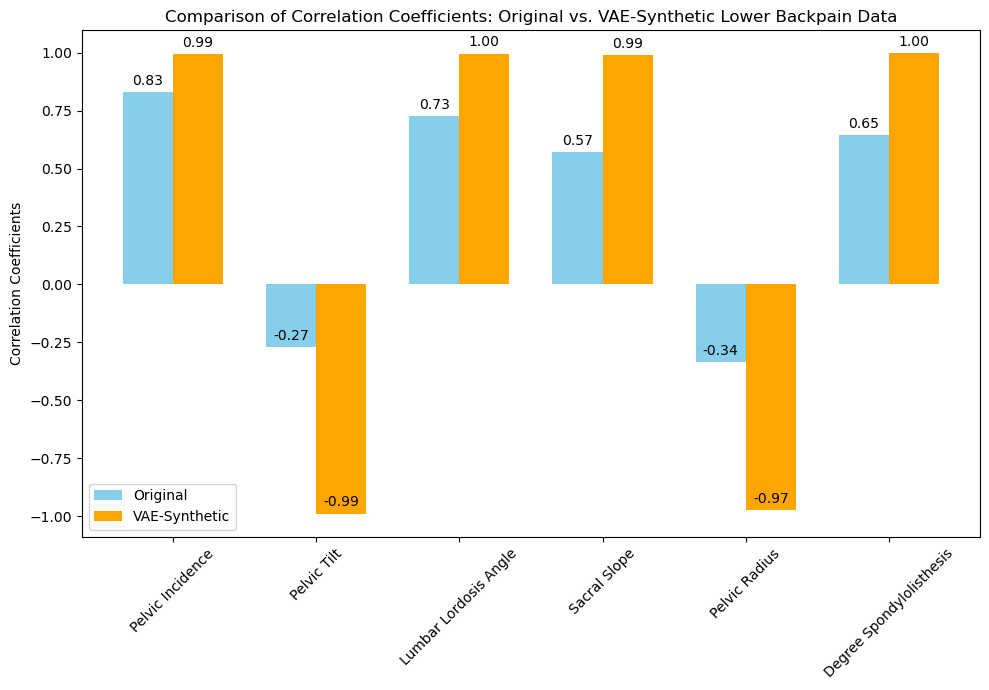

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar graph
features = ['Pelvic Incidence', 'Pelvic Tilt', 'Lumbar Lordosis Angle', 
            'Sacral Slope', 'Pelvic Radius', 'Degree Spondylolisthesis']
original_correlations = [0.831, -0.270, 0.726, 0.570, -0.336, 0.646]
synthetic_correlations = [0.993, -0.989, 0.996, 0.988, -0.975, 0.997]

x = np.arange(len(features))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, original_correlations, width, label='Original', color='skyblue')
rects2 = ax.bar(x + width/2, synthetic_correlations, width, label='VAE-Synthetic', color='orange')

# Adding labels, title and custom x-axis tick labels
ax.set_ylabel('Correlation Coefficients')
ax.set_title('Comparison of Correlation Coefficients: Original vs. VAE-Synthetic Lower Backpain Data')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45)
ax.legend()

# Adding text labels above bars for clarity
def autolabel(rects):
    """Attach a text label above each bar, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


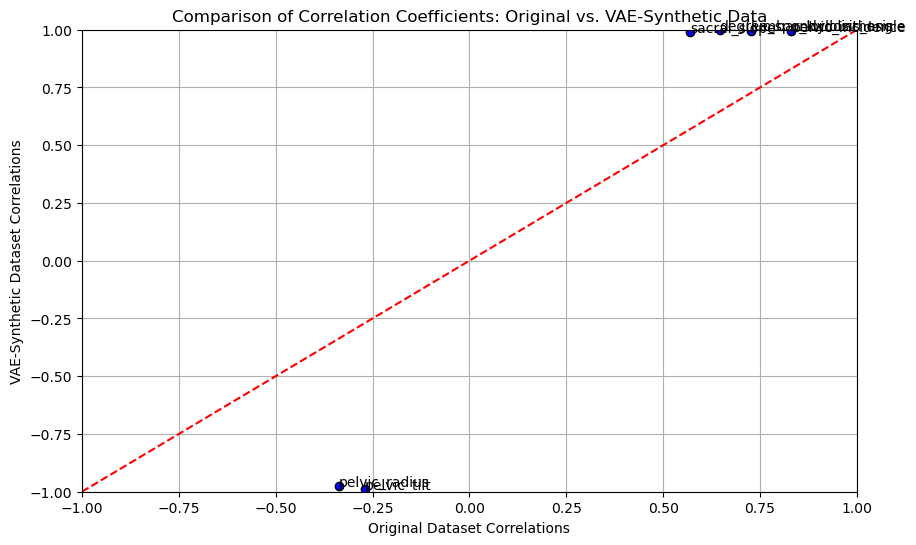

In [107]:
import matplotlib.pyplot as plt

# Data for plotting
features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
original_correlations = [0.831, -0.270, 0.726, 0.570, -0.336, 0.646]
synthetic_correlations = [0.993, -0.989, 0.996, 0.988, -0.975, 0.997]

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(original_correlations, synthetic_correlations, color='blue', edgecolors='black')

# Annotating the plot
for i, txt in enumerate(features):
    plt.annotate(txt, (original_correlations[i], synthetic_correlations[i]))

# Adding plot details
plt.title('Comparison of Correlation Coefficients: Original vs. VAE-Synthetic Data')
plt.xlabel('Original Dataset Correlations')
plt.ylabel('VAE-Synthetic Dataset Correlations')
plt.plot([-1, 1], [-1, 1], 'r--') # Line of perfect agreement
plt.grid(True)
plt.axis([-1, 1, -1, 1])  # Setting the limits for better visualization
plt.show()


# IMPORTING THE INSTALLED ANONYMETER'S PRIVACY RISK EVALUATORS FOR PRIVACY PRESERVATION ASSESSMENT ON THE GENERATED SYNTHETIC DATASET
For more detailed information on the usage of this tool do visit the author's website(blogger) via the links below.

https://www.anonos.com/blog/presenting-anonymeter-the-tool-for-assessing-privacy-risks-in-synthetic-datasets

https://github.com/statice/anonymeter

In [78]:
import pandas as pd
from anonymeter.evaluators import SinglingOutEvaluator, LinkabilityEvaluator, InferenceEvaluator

# STEP 3A: PRIVACY RISK ASSESSMENT VIA UNIVARIATE MODE ON 80% VAE-SYNTHETIC LOWER BACK PAIN DATASET

In [52]:
singling = SinglingOutEvaluator(ori=lowerBackPain_train_dataframe, 
                                              syn=vae_synthetic_backpain_data_with_labels_df, 
                                              control=control_lbp_dataframe,
                                              n_attacks=1500)

try:
    singling.evaluate(mode='univariate')  # For univariate analysis
    # For multivariate analysis, you can change mode to 'multivariate'
    singling_out_risk = singling.risk()
    print("Singling Out Risk for Univariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain:", singling_out_risk)
except RuntimeError as ex:
    print(f"Singling out evaluation failed: {ex}")

Singling Out Risk for Univariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain: PrivacyRisk(value=0.0, ci=(0.0, 0.0018085652115795217))


C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.001277215360090744, baseline = 0.001277215360090744. Analysis results cannot be trusted.
  self._sanity_check()


In [53]:
result = singling.results()

print("The Singling Out Risk Type in Univariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain:")
print("Successs rate of main attack:", result.attack_rate)
print("Successs rate of baseline attack:", result.baseline_rate)
print("Successs rate of control attack:", result.control_rate)

The Singling Out Risk Type in Univariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain:
Successs rate of main attack: SuccessRate(value=0.001277215360090744, error=0.001277215360090744)
Successs rate of baseline attack: SuccessRate(value=0.001277215360090744, error=0.001277215360090744)
Successs rate of control attack: SuccessRate(value=0.001277215360090744, error=0.001277215360090744)


In [55]:
singling1 = SinglingOutEvaluator(ori=lowerBackPain_train_dataframe, 
                                              syn=vae_synthetic_backpain_data_with_labels_df, 
                                              control=control_lbp_dataframe,
                                              n_attacks=500)

try:
    singling1.evaluate(mode='univariate')  # For univariate analysis
    # For multivariate analysis, you can change mode to 'multivariate'
    singling_out_risk = singling1.risk()
    print("Singling Out Risk for Univariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain:", singling_out_risk)
except RuntimeError as ex:
    print(f"Singling out evaluation failed: {ex}")

Singling Out Risk for Univariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain: PrivacyRisk(value=0.0, ci=(0.0, 0.005411853750198381))


C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0038121702307761206, baseline = 0.0038121702307761206. Analysis results cannot be trusted.
  self._sanity_check()


In [56]:
result1 = singling1.results()

print("The Singling Out Risk Type in Univariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain:")
print("Successs rate of main attack:", result1.attack_rate)
print("Successs rate of baseline attack:", result1.baseline_rate)
print("Successs rate of control attack:", result1.control_rate)

The Singling Out Risk Type in Univariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain:
Successs rate of main attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of baseline attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of control attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)


# GRAPHICAL REPRESENTATIONS OF THE ABOVE PRIVACY RISK NUMERICAL RESULTS

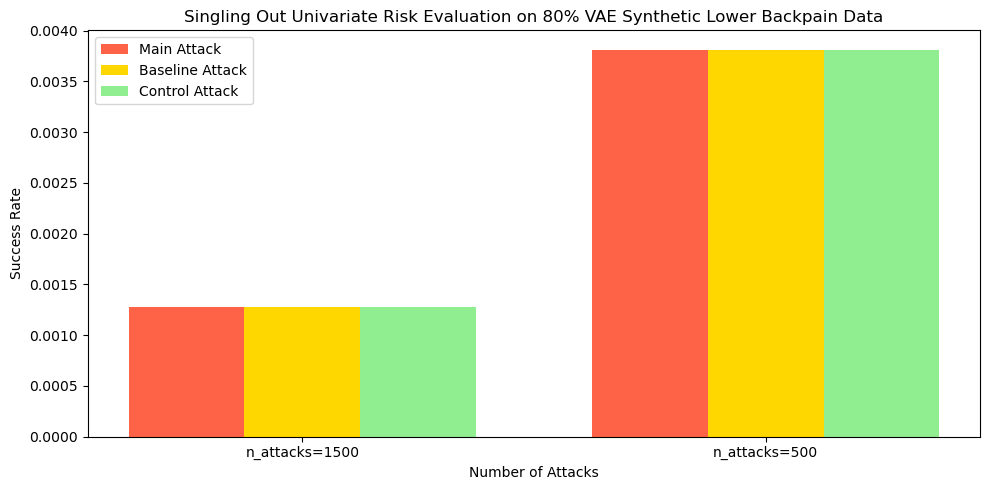

In [143]:
# Singling out risk data in univariate mode
data_singling_out_univariate = [
    ('n_attacks=1500', 0.001277215360090744),
    ('n_attacks=500', 0.0038121702307761206)
]

# Convert to DataFrame
df_singling_out_univariate = pd.DataFrame(data_singling_out_univariate, columns=['Evaluation', 'SuccessRateMainAttack'])

# Add baseline and control attack success rates (same as main attack in univariate)
df_singling_out_univariate['SuccessRateBaselineAttack'] = df_singling_out_univariate['SuccessRateMainAttack']
df_singling_out_univariate['SuccessRateControlAttack'] = df_singling_out_univariate['SuccessRateMainAttack']

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(len(df_singling_out_univariate))
bar_width = 0.25

bars1 = plt.bar(index, df_singling_out_univariate['SuccessRateMainAttack'], bar_width, label='Main Attack', color='tomato')
bars2 = plt.bar(index + bar_width, df_singling_out_univariate['SuccessRateBaselineAttack'], bar_width, label='Baseline Attack', color='gold')
bars3 = plt.bar(index + 2 * bar_width, df_singling_out_univariate['SuccessRateControlAttack'], bar_width, label='Control Attack', color='lightgreen')

plt.xlabel('Number of Attacks')
plt.ylabel('Success Rate')
plt.title('Singling Out Univariate Risk Evaluation on 80% VAE Synthetic Lower Backpain Data')
plt.xticks(index + bar_width, df_singling_out_univariate['Evaluation'])
plt.legend()

plt.tight_layout()
plt.show()


Univariate Risk Assessment Success/Overall Success vs. Failure Rates via 1500 and 500 Attacks on 80% VAE Synthetic Lower Backpain


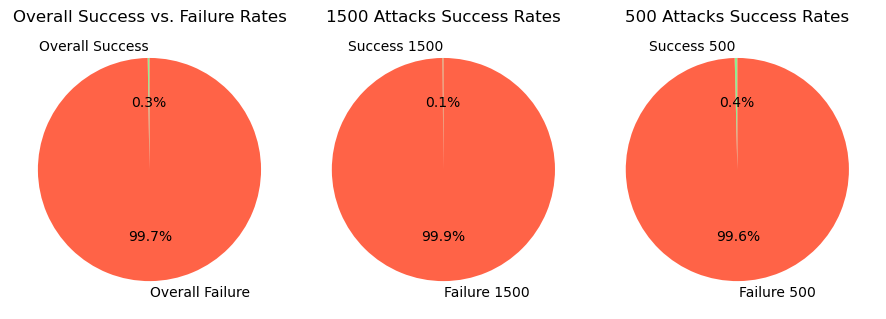

In [113]:
import matplotlib.pyplot as plt

print('Univariate Risk Assessment Success/Overall Success vs. Failure Rates via 1500 and 500 Attacks on 80% VAE Synthetic Lower Backpain')

# Data for plotting
attacks_1500 = ['Success 1500', 'Failure 1500']
success_rates_1500 = [0.001277, 1-0.001277]  # Success and failure rates for 1500 attacks
attacks_500 = ['Success 500', 'Failure 500']
success_rates_500 = [0.003812, 1-0.003812]  # Success and failure rates for 500 attacks
total_success = (0.001277 + 0.003812) / 2
total_failure = 1 - total_success

# Define colors
colors = ['lightgreen', 'tomato']

# Overall success vs. failure rates for all attacks
plt.figure(figsize=(12, 6))

# Overall success vs. failure
plt.subplot(1, 4, 1)
plt.pie([total_success, total_failure], labels=['Overall Success', 'Overall Failure'], colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Overall Success vs. Failure Rates')

# Plot for 1500 Attacks
plt.subplot(1, 4, 2)
plt.pie(success_rates_1500, labels=attacks_1500, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('1500 Attacks Success Rates')

# Plot for 500 Attacks
plt.subplot(1, 4, 3)
plt.pie(success_rates_500, labels=attacks_500, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('500 Attacks Success Rates')

plt.tight_layout()
plt.show()


# STEP 3B: PRIVACY RISK ASSESSMENT VIA MULTIVARIATE MODE ON 80% VAE-SYNTHETIC LOWER BACK PAIN DATASET

In [57]:
singling2 = SinglingOutEvaluator(ori=lowerBackPain_train_dataframe, 
                                              syn=vae_synthetic_backpain_data_with_labels_df, 
                                              control=control_lbp_dataframe,
                                              n_attacks=1500)

try:
    singling2.evaluate(mode='multivariate')  # For univariate analysis
    # For multivariate analysis, you can change mode to 'multivariate'
    singling_out_risk = singling2.risk()
    print("Singling Out Risk for Multivariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain:", singling_out_risk)
except RuntimeError as ex:
    print(f"Singling out evaluation failed: {ex}")

Singling Out Risk for Multivariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain: PrivacyRisk(value=0.0, ci=(0.0, 0.0))


C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.001277215360090744, baseline = 0.002607142785797169. Analysis results cannot be trusted.
  self._sanity_check()


In [59]:
result2 = singling2.results()

print("The Singling Out Risk Type in Multivariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain:")
print("Successs rate of main attack:", result2.attack_rate)
print("Successs rate of baseline attack:", result2.baseline_rate)
print("Successs rate of control attack:", result2.control_rate)

The Singling Out Risk Type in Multivariate Analysis When n_attacks=1500 for VAE Synthetic Data Backpain:
Successs rate of main attack: SuccessRate(value=0.001277215360090744, error=0.001277215360090744)
Successs rate of baseline attack: SuccessRate(value=0.002607142785797169, error=0.002241418510213043)
Successs rate of control attack: SuccessRate(value=0.009857650739252218, error=0.004833307158448708)


In [60]:
singling3 = SinglingOutEvaluator(ori=lowerBackPain_train_dataframe, 
                                              syn=vae_synthetic_backpain_data_with_labels_df, 
                                              control=control_lbp_dataframe,
                                              n_attacks=500)

try:
    singling3.evaluate(mode='multivariate')  # For univariate analysis
    # For multivariate analysis, you can change mode to 'multivariate'
    singling_out_risk = singling3.risk()
    print("Singling Out Risk for Multivariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain:", singling_out_risk)
except RuntimeError as ex:
    print(f"Singling out evaluation failed: {ex}")

Singling Out Risk for Multivariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain: PrivacyRisk(value=0.0, ci=(0.0, 0.0))


In [61]:
result3 = singling3.results()

print("The Singling Out Risk Type in Multivariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain:")
print("Successs rate of main attack:", result3.attack_rate)
print("Successs rate of baseline attack:", result3.baseline_rate)
print("Successs rate of control attack:", result3.control_rate)

The Singling Out Risk Type in Multivariate Analysis When n_attacks=500 for VAE Synthetic Data Backpain:
Successs rate of main attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of baseline attack: SuccessRate(value=0.0038121702307761206, error=0.00381217023077612)
Successs rate of control attack: SuccessRate(value=0.014357656155028058, error=0.00969951651191585)


# GRAPHICAL REPRESENTATIONS OF THE ABOVE PRIVACY RISK NUMERICAL RESULTS

In [136]:
import pandas as pd

data = {
    'Attack Type': ['Main Attack', 'Baseline Attack', 'Control Attack', 'Main Attack', 'Baseline Attack', 'Control Attack'],
    'Number of Attacks': ['1500', '1500', '1500', '500', '500', '500'],
    'Success Rate (%)': [0.0013, 0.0026, 0.0099, 0.0038, 0.0038, 0.0144]
}

df = pd.DataFrame(data)
print(df)

       Attack Type Number of Attacks  Success Rate (%)
0      Main Attack              1500            0.0013
1  Baseline Attack              1500            0.0026
2   Control Attack              1500            0.0099
3      Main Attack               500            0.0038
4  Baseline Attack               500            0.0038
5   Control Attack               500            0.0144


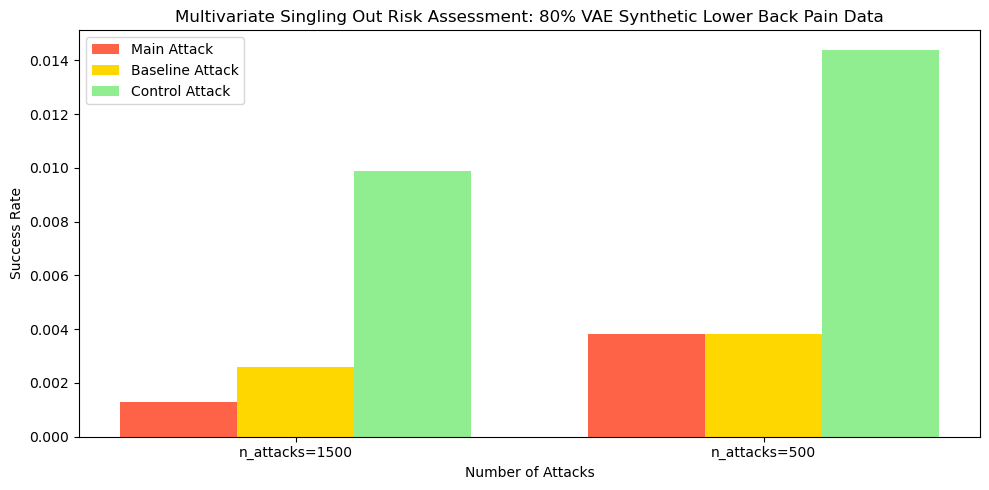

In [145]:
# Singling out risk data
data_singling_out = [
    ('n_attacks=1500', 0.0013),
    ('n_attacks=500', 0.0038)
]

# Convert to DataFrame
df_singling_out = pd.DataFrame(data_singling_out, columns=['Evaluation', 'SuccessRateMainAttack'])

# Add baseline and control attack success rates
df_singling_out['SuccessRateBaselineAttack'] = [0.0026, 0.0038]
df_singling_out['SuccessRateControlAttack'] = [0.0099, 0.0144]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(len(df_singling_out))
bar_width = 0.25

bars1 = plt.bar(index, df_singling_out['SuccessRateMainAttack'], bar_width, label='Main Attack', color='tomato')
bars2 = plt.bar(index + bar_width, df_singling_out['SuccessRateBaselineAttack'], bar_width, label='Baseline Attack', color='gold')
bars3 = plt.bar(index + 2 * bar_width, df_singling_out['SuccessRateControlAttack'], bar_width, label='Control Attack', color='lightgreen')

plt.xlabel('Number of Attacks')
plt.ylabel('Success Rate')
plt.title('Multivariate Singling Out Risk Assessment: 80% VAE Synthetic Lower Back Pain Data')
plt.xticks(index + bar_width, df_singling_out['Evaluation'])
plt.legend()

plt.tight_layout()
plt.show()


Multivariate Risk Assessment Success/Overall Success vs. Failure Rates via 1500 and 500 Attacks for 80% VAE Synthetic Lower Backpain


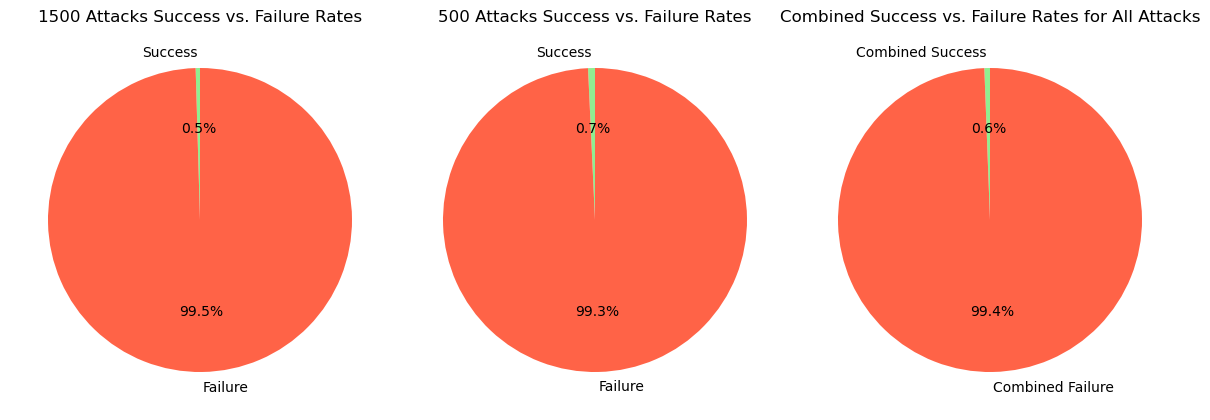

In [148]:
# Recalculating the overall success rate by averaging individual attack success rates
overall_success_1500 = sum(success_rates_1500) / len(success_rates_1500)
overall_failure_1500 = 1 - overall_success_1500

overall_success_500 = sum(success_rates_500) / len(success_rates_500)
overall_failure_500 = 1 - overall_success_500

combined_success = (overall_success_1500 + overall_success_500) / 2
combined_failure = 1 - combined_success

# Setting up the plot
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

print('Multivariate Risk Assessment Success/Overall Success vs. Failure Rates via 1500 and 500 Attacks for 80% VAE Synthetic Lower Backpain')

# 1500 Attacks Success vs. Failure Rates
axs[0].pie([overall_success_1500, overall_failure_1500], labels=['Success', 'Failure'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'], startangle=90)
axs[0].set_title('1500 Attacks Success vs. Failure Rates')

# 500 Attacks Success vs. Failure Rates
axs[1].pie([overall_success_500, overall_failure_500], labels=['Success', 'Failure'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'], startangle=90)
axs[1].set_title('500 Attacks Success vs. Failure Rates')

# Combined Success vs. Failure Rates
axs[2].pie([combined_success, combined_failure], labels=['Combined Success', 'Combined Failure'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'], startangle=90)
axs[2].set_title('Combined Success vs. Failure Rates for All Attacks')

plt.tight_layout()
plt.show()


# STEP 4: PRIVACY RISK ASSESSMENT VIA LINKABILITY ON 80% VAE-SYNTHETIC LOWER BACK PAIN DATASET

In [65]:
# Dynamically setting n_attacks based on the smallest dataset size
min_dataset_size = min(len(lowerBackPain_train_dataframe), len(vae_synthetic_backpain_data_with_labels_df), len(control_lbp_dataframe))
n_attacks = min_dataset_size  # Or some fraction of the smallest size, if desired

aux_cols = [
    ['pelvic_incidence', 'pelvic_tilt'],  # Attributes in dataset A
    ['sacral_slope', 'pelvic_radius']     # Attributes in dataset B
]

linkability = LinkabilityEvaluator(ori=lowerBackPain_train_dataframe, 
                                             syn=vae_synthetic_backpain_data_with_labels_df, 
                                             control=control_lbp_dataframe,
                                             n_attacks=n_attacks,
                                             aux_cols=aux_cols,
                                             n_neighbors=10)

linkability.evaluate(n_jobs=-1)  # Adjust 'n_jobs' as needed
linkability_risks = linkability.risk()
print("Linkability Risk When the n_attacks = the smallest size of dataset and n_neighbors = 10 for VAE Synthetic Backpain Data:", linkability_risks)

Linkability Risk When the n_attacks = the smallest size of dataset and n_neighbors = 10 for VAE Synthetic Backpain Data: PrivacyRisk(value=0.0, ci=(0.0, 0.045318907972728195))


C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.24180401976973115, baseline = 0.332932012792179. Analysis results cannot be trusted.
  self._sanity_check()


In [66]:
linkabel = linkability.results()

print("Linkability When n_neighbors=10 for VAE Synthetic Backpain Data:")
print("Successs rate of main attack:", linkabel.attack_rate)
print("Successs rate of baseline attack:", linkabel.baseline_rate)
print("Successs rate of control attack:", linkabel.control_rate)

Linkability When n_neighbors=10 for VAE Synthetic Backpain Data:
Successs rate of main attack: SuccessRate(value=0.24180401976973115, error=0.10225218938384836)
Successs rate of baseline attack: SuccessRate(value=0.332932012792179, error=0.11338710627934007)
Successs rate of control attack: SuccessRate(value=0.39368400814047755, error=0.11783755646933888)


In [70]:
# Dynamically setting n_attacks based on the smallest dataset size
min_dataset_size = min(len(lowerBackPain_train_dataframe), len(vae_synthetic_backpain_data_with_labels_df), len(control_lbp_dataframe))
n_attacks = min_dataset_size  # Or some fraction of the smallest size, if desired

aux_cols = [
    ['pelvic_incidence', 'pelvic_tilt'],  # Attributes in dataset A
    ['sacral_slope', 'pelvic_radius']     # Attributes in dataset B
]

linkability1 = LinkabilityEvaluator(ori=lowerBackPain_train_dataframe, 
                                             syn=vae_synthetic_backpain_data_with_labels_df, 
                                             control=control_lbp_dataframe,
                                             n_attacks=n_attacks,
                                             aux_cols=aux_cols,
                                             n_neighbors=5)

linkability1.evaluate(n_jobs=-1)  # Adjust 'n_jobs' as needed
linkability_risks = linkability1.risk()
print("Linkability Risk When the n_attacks = the smallest size of dataset and n_neighbors = 5 for VAE Synthetic Backpain Data:", linkability_risks)

Linkability Risk When the n_attacks = the smallest size of dataset and n_neighbors = 5 for VAE Synthetic Backpain Data: PrivacyRisk(value=0.05006614621553592, ci=(0.0, 0.16056968349480336))


C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.1354880279102087, baseline = 0.15067602674728334. Analysis results cannot be trusted.
  self._sanity_check()


In [72]:
linkabel1 = linkability1.results()

print("Linkability When n_neighbors=10 for VAE Synthetic Backpain Data:")
print("Successs rate of main attack:", linkabel1.attack_rate)
print("Successs rate of baseline attack:", linkabel1.baseline_rate)
print("Successs rate of control attack:", linkabel1.control_rate)

Linkability When n_neighbors=10 for VAE Synthetic Backpain Data:
Successs rate of main attack: SuccessRate(value=0.1354880279102087, error=0.07970939261620902)
Successs rate of baseline attack: SuccessRate(value=0.15067602674728334, error=0.08381724615445296)
Successs rate of control attack: SuccessRate(value=0.08992403139898479, error=0.06455112587854399)


# GRAPHICAL REPRESENTATIONS OF THE ABOVE PRIVACY RISK NUMERICAL RESULTS

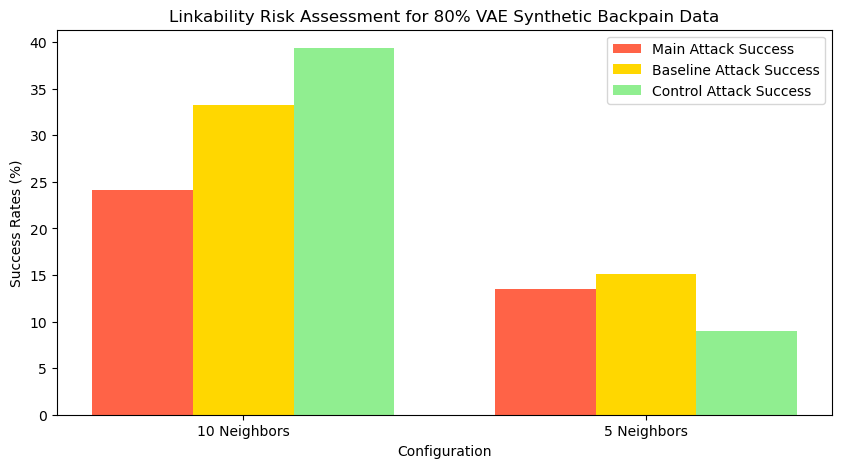

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
categories = ['10 Neighbors', '5 Neighbors']
main_attack_success_rates = [24.18, 13.55]  # Updated with provided success rates
baseline_attack_success_rates = [33.29, 15.07]
control_attack_success_rates = [39.37, 8.99]

x = np.arange(len(categories))  # the label locations
bar_width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - bar_width, main_attack_success_rates, width=bar_width, label='Main Attack Success', color='tomato')
plt.bar(x, baseline_attack_success_rates, width=bar_width, label='Baseline Attack Success', color='gold')
plt.bar(x + bar_width, control_attack_success_rates, width=bar_width, label='Control Attack Success', color='lightgreen')

plt.xlabel('Configuration')
plt.ylabel('Success Rates (%)')
plt.title('Linkability Risk Assessment for 80% VAE Synthetic Backpain Data')
plt.xticks(x, categories)
plt.legend()
plt.show()


Linkability Risk Assessment Success/Overall Success vs. Failure Rates via 10 and 5 Neighbors on 80% VAE Synthetic Lower Backpain Dataset


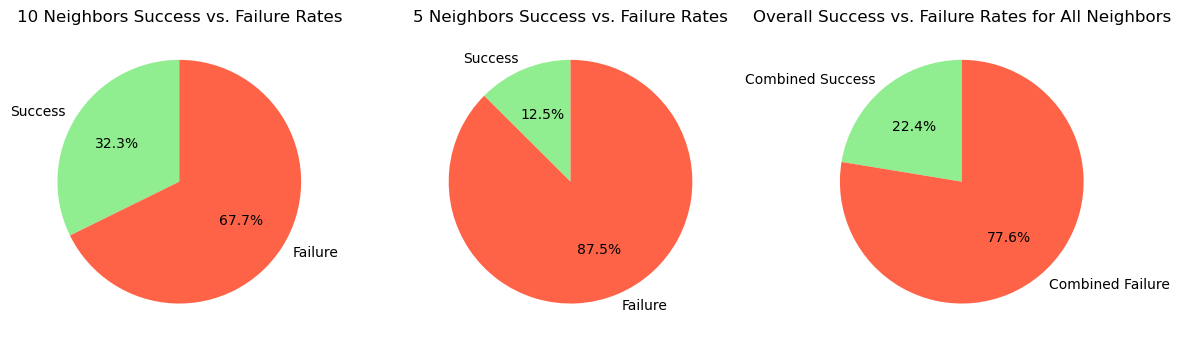

In [5]:
print('Linkability Risk Assessment Success/Overall Success vs. Failure Rates via 10 and 5 Neighbors on 80% VAE Synthetic Lower Backpain Dataset')


# Success rates from previous explanation with 10 and 5 neighbors
success_rates_10_neighbors = [0.241804, 0.332932, 0.393684]  # Main, Baseline, Control for 10 neighbors
success_rates_5_neighbors = [0.135488, 0.150676, 0.089924]  # Main, Baseline, Control for 5 neighbors

# Calculating failure rates by subtracting success rates from 1
failure_rates_10_neighbors = [1 - rate for rate in success_rates_10_neighbors]
failure_rates_5_neighbors = [1 - rate for rate in success_rates_5_neighbors]

# Combined success and failure rates for overall
combined_success_rates = [(x + y) / 2 for x, y in zip(success_rates_10_neighbors, success_rates_5_neighbors)]
combined_failure_rates = [1 - x for x in combined_success_rates]

# Setting up the plot for three pie charts
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# 10 Neighbors Success vs. Failure Rates
axs[0].pie([sum(success_rates_10_neighbors), sum(failure_rates_10_neighbors)], labels=['Success', 'Failure'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'], startangle=90)
axs[0].set_title('10 Neighbors Success vs. Failure Rates')

# 5 Neighbors Success vs. Failure Rates
axs[1].pie([sum(success_rates_5_neighbors), sum(failure_rates_5_neighbors)], labels=['Success', 'Failure'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'], startangle=90)
axs[1].set_title('5 Neighbors Success vs. Failure Rates')

# Overall Combined Success vs. Failure Rates
axs[2].pie([sum(combined_success_rates), sum(combined_failure_rates)], labels=['Combined Success', 'Combined Failure'], autopct='%1.1f%%', colors=['lightgreen', 'tomato'], startangle=90)
axs[2].set_title('Overall Success vs. Failure Rates for All Neighbors')

plt.tight_layout()
plt.show()


# STEP 5: PRIVACY RISK ASSESSMENT VIA INFERENCE PER COLUMN ON 80% VAE-SYNTHETIC LOWER BACK PAIN DATASET

C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.15067602674728334, baseline = 0.18105202442143262. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.07473603256191015, baseline = 0.1354880279102087. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.12030002907313406, baseline = 0.18105202442143262. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\Ede\anaconda3\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.287368016280955

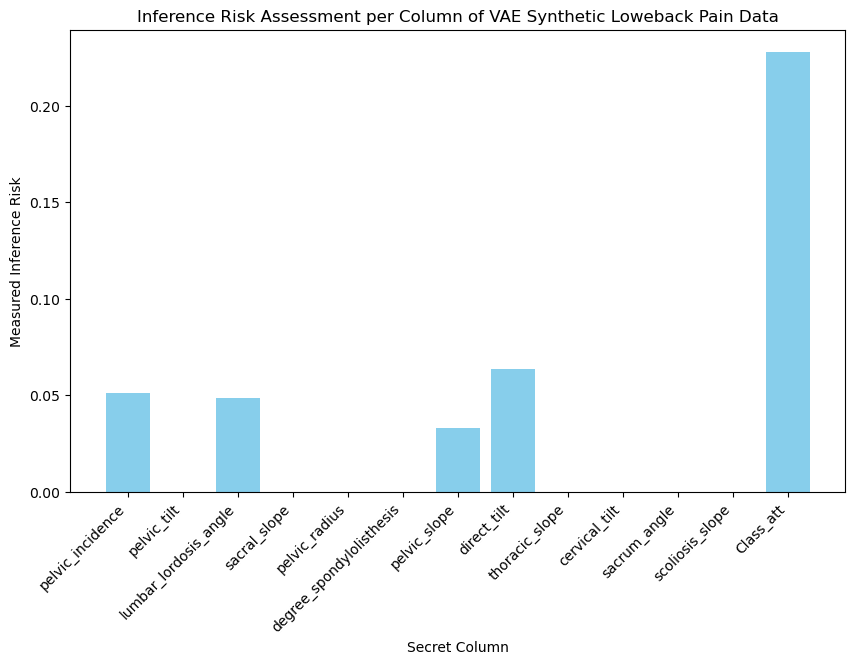

In [114]:
# Dynamically setting n_attacks based on the smallest dataset size
min_dataset_size = min(len(lowerBackPain_train_dataframe), len(vae_synthetic_backpain_data_with_labels_df), len(control_lbp_dataframe))
n_attacks_attempted = min_dataset_size  # Or some fraction of the smallest size, if desired


columns = lowerBackPain_train_dataframe.columns
inference_res = []

for secret in columns:
    aux_cols = [col for col in columns if col != secret]
    
    evaluator_inferen4 = InferenceEvaluator(ori=lowerBackPain_train_dataframe, 
                                   syn=vae_synthetic_backpain_data_with_labels_df, 
                                   control=control_lbp_dataframe,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=n_attacks_attempted) # Use the dynamically set value
    evaluator_inferen4.evaluate(n_jobs=-1)  # Adjust 'n_jobs' as needed
    inference_res.append((secret,  evaluator_inferen4.risk()))

# Plotting the inference risks
import matplotlib.pyplot as plt

risks = [res[1].value for res in inference_res]
columns = [res[0] for res in inference_res]

plt.figure(figsize=(10, 6))
plt.bar(columns, risks, color='skyblue')
plt.xlabel('Secret Column')
plt.ylabel('Measured Inference Risk')
plt.xticks(rotation=45, ha='right')
plt.title('Inference Risk Assessment per Column of VAE Synthetic Loweback Pain Data')
plt.show()

In [123]:
print('Inference Risk Assessment on VAE Synthetic Loweback Pain Data when n_attempted_attacks = smallest dataset size used:', inference_res)

Inference Risk Assessment on VAE Synthetic Loweback Pain Data when n_attempted_attacks = smallest dataset size used: [('pelvic_incidence', PrivacyRisk(value=0.05091586662321887, ci=(0.0, 0.17054648766272262))), ('pelvic_tilt', PrivacyRisk(value=0.0, ci=(0.0, 0.07965532676220312))), ('lumbar_lordosis_angle', PrivacyRisk(value=0.048449041679064817, ci=(0.0, 0.13897371857928884))), ('sacral_slope', PrivacyRisk(value=0.0, ci=(0.0, 0.08814616072170517))), ('pelvic_radius', PrivacyRisk(value=0.0, ci=(0.0, 0.11488789879466324))), ('degree_spondylolisthesis', PrivacyRisk(value=0.0, ci=(0.0, 0.06995620518713111))), ('pelvic_slope', PrivacyRisk(value=0.032829547829745946, ci=(0.0, 0.1300196578111711))), ('direct_tilt', PrivacyRisk(value=0.0635720538761303, ci=(0.0, 0.14751485913118417))), ('thoracic_slope', PrivacyRisk(value=0.0, ci=(0.0, 0.13956451248918328))), ('cervical_tilt', PrivacyRisk(value=0.0, ci=(0.0, 0.09290664531326398))), ('sacrum_angle', PrivacyRisk(value=0.0, ci=(0.0, 1.0))), ('sc

In [116]:
Infere1 = evaluator_inferen4.results()

print("Inference Risk When n_attacks_attempted = min_dataset_size for VAE Synthetic Backpain Data:")
print("Successs rate of main attack:", Infere1.attack_rate)
print("Successs rate of baseline attack:", Infere1.baseline_rate)
print("Successs rate of control attack:", Infere1.control_rate)

Inference Risk When n_attacks_attempted = min_dataset_size for VAE Synthetic Backpain Data:
Successs rate of main attack: SuccessRate(value=0.7430079813931942, error=0.10453305655346831)
Successs rate of baseline attack: SuccessRate(value=0.4544360034887761, error=0.12023887181278083)
Successs rate of control attack: SuccessRate(value=0.667067987207821, error=0.11338710627934007)


# GRAPHICAL REPRESENTATIONS OF THE ABOVE PRIVACY RISK NUMERICAL RESULTS

In [117]:
import pandas as pd

# Convert success rates from fractions to percentages and round to two decimal places
main_attack_success_rate = round(0.7430079813931942 * 100, 2)
baseline_attack_success_rate = round(0.4544360034887761 * 100, 2)
control_attack_success_rate = round(0.667067987207821 * 100, 2)

data = {
    'Attack Type': ['Main Attack', 'Baseline Attack', 'Control Attack'],
    'Success Rate (%)': [main_attack_success_rate, baseline_attack_success_rate, control_attack_success_rate],
}

df = pd.DataFrame(data)
print(df)


       Attack Type  Success Rate (%)
0      Main Attack             74.30
1  Baseline Attack             45.44
2   Control Attack             66.71


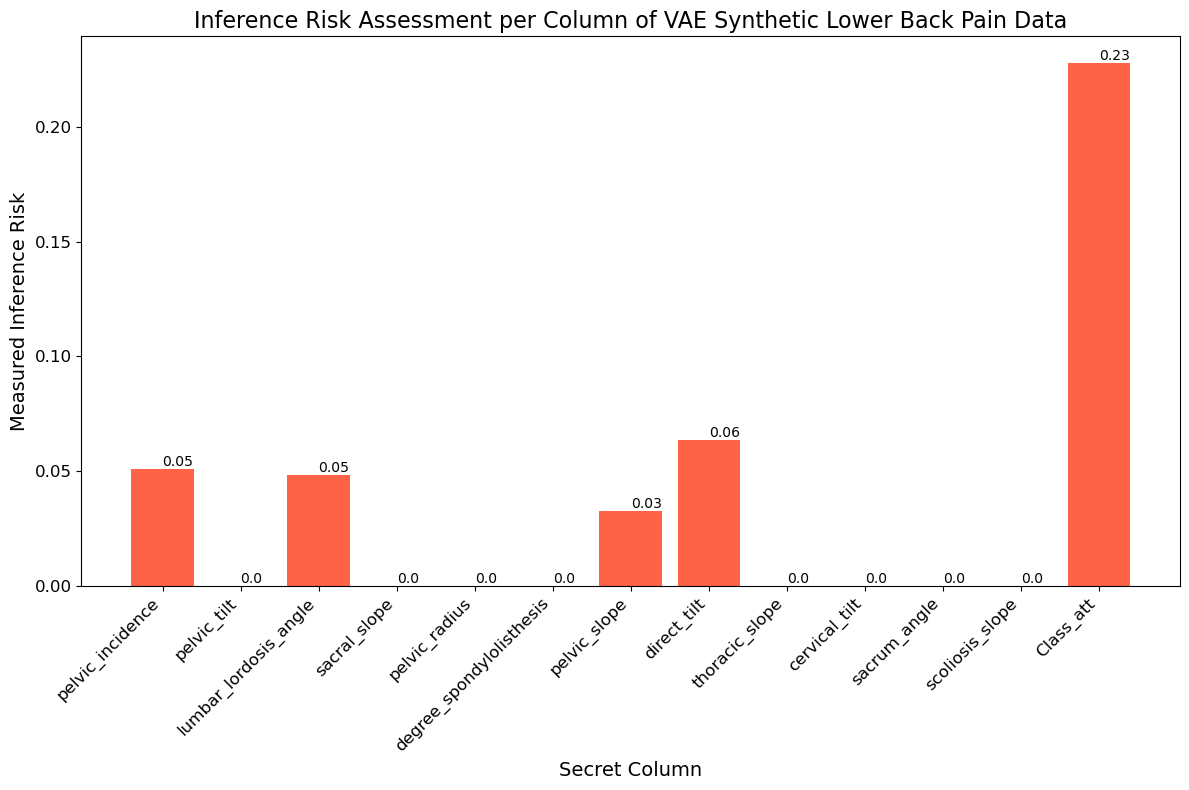

In [118]:
import matplotlib.pyplot as plt

# Extracting risk values and columns for plotting
risks = [res[1].value for res in inference_res]
columns = [res[0] for res in inference_res]

plt.figure(figsize=(12, 8))
bars = plt.bar(columns, risks, color='tomato')

plt.xlabel('Secret Column', fontsize=14)
plt.ylabel('Measured Inference Risk', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Inference Risk Assessment per Column of VAE Synthetic Lower Back Pain Data', fontsize=16)

# Adding the risk value above each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval,2), va='bottom') # va: vertical alignment

plt.tight_layout()
plt.show()


Success and Failure Rates for Different Attack Types by Inference Risk Per Column on 80% VAE Synthetic Lower Back Pain Dataset


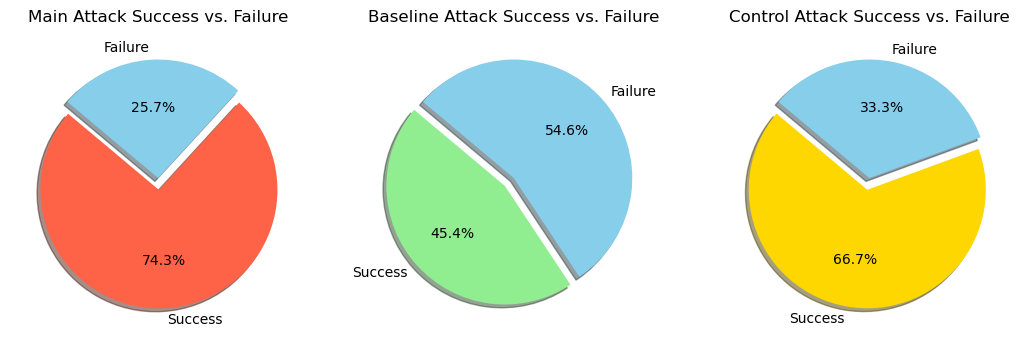

In [6]:
import matplotlib.pyplot as plt

print('Success and Failure Rates for Different Attack Types by Inference Risk Per Column on 80% VAE Synthetic Lower Back Pain Dataset')

# Success rates and failure for each attack based on provided data
attacks_data = {
    'Main Attack': 0.7430079813931942,
    'Baseline Attack': 0.4544360034887761,
    'Control Attack': 0.667067987207821,
}

# Adding failure rates by calculating the complement to 1 for each
failure_rates = {key: 1 - value for key, value in attacks_data.items()}

# Colors for the pie chart
colors = ['tomato', 'lightgreen', 'gold']

# Exploding the 1st slice (i.e. 'Overall Success')
explode = (0.1, 0) 

# Create pie charts for each type of attack
fig, axs = plt.subplots(1, 3, figsize=(13, 8))

for i, (key, value) in enumerate(attacks_data.items()):
    axs[i].pie([value, failure_rates[key]], labels=['Success', 'Failure'], explode=explode, colors=[colors[i], 'skyblue'], autopct='%1.1f%%', shadow=True, startangle=140)
    axs[i].set_title(f'{key} Success vs. Failure')

plt.show()


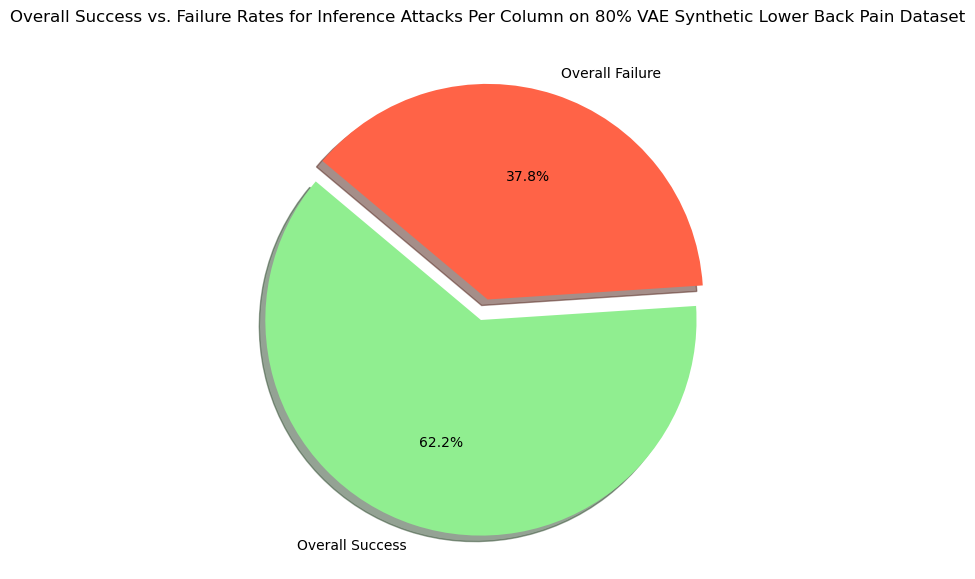

In [3]:
import matplotlib.pyplot as plt

# Values from the previous text snippet for the highest risk attribute
success_rate_main = 0.7430079813931942
success_rate_baseline = 0.4544360034887761
success_rate_control = 0.667067987207821

# Calculate the overall success rate by averaging the success rates
overall_success_rate = (success_rate_main + success_rate_baseline + success_rate_control) / 3
overall_failure_rate = 1 - overall_success_rate

# Data to plot
labels = 'Overall Success', 'Overall Failure'
sizes = [overall_success_rate, overall_failure_rate]
colors = ['lightgreen', 'tomato']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Overall Success vs. Failure Rates for Inference Attacks Per Column on 80% VAE Synthetic Lower Back Pain Dataset')
plt.show()


Inference Risk Assessment


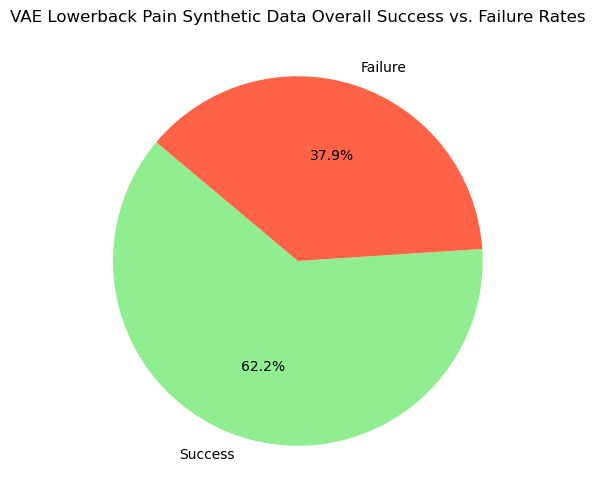

In [161]:
# Example success and failure rates (these should be actual values based on your data or calculations)
success_rate = 0.6215  # 70% success rate (as an example, replace with your actual calculation)
failure_rate = 1 - success_rate  # 30% failure rate

print('Inference Risk Assessment')
# Data to plot
rates = [success_rate, failure_rate]
labels = ['Success', 'Failure']
colors = ['lightgreen', 'tomato']

plt.figure(figsize=(6, 6))
plt.pie(rates, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('VAE Lowerback Pain Synthetic Data Overall Success vs. Failure Rates')
plt.show()
